## Modeling Notebook

In [62]:
#imports
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pylab as plt
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
import statsmodels.api as sm

In [63]:
##Importing relevant data set
df_FF = pd.read_csv("../Data/Federal_Funds_Rate.csv")
df_FF['DATE'] = pd.to_datetime(df_FF.DATE)
df_FF = df_FF.set_index(pd.to_datetime(df_FF['DATE']), drop=True)
df_FF.drop('DATE', axis=1, inplace=True)
df_FF = df_FF['1971-07-01':'2022-04-01']
df_FF

,FEDFUNDS
DATE,
1971-07-01,5.31
1971-08-01,5.57
1971-09-01,5.55
1971-10-01,5.20
1971-11-01,4.91
...,...
2021-12-01,0.08
2022-01-01,0.08
2022-02-01,0.08


## Train-Test Split 

In [64]:
#Splitting off 30% of the data set to make a test data set
df_cutoff = round(df_FF.shape[0]*0.70)
df_cutoff

427

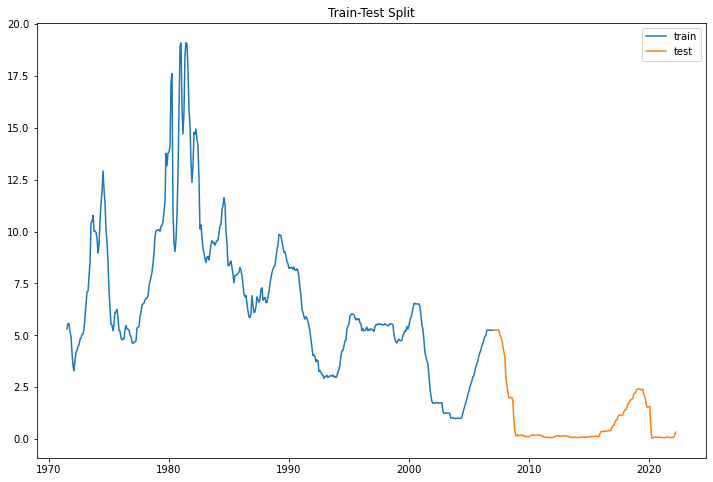

In [65]:
#Defining our train and test set, visualizing them as well
train = df_FF[:df_cutoff]

test = df_FF[df_cutoff:]

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

##  Creating a Validation Data Set 

In [66]:
#Creating a validation data set within the original train set with 5 folds
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71] [ 72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 

## Baseline Model

In [67]:
#Building a Naive Baseline Model with one lag
naive = train.shift(1)
naive

,FEDFUNDS
DATE,
1971-07-01,NaN
1971-08-01,5.31
1971-09-01,5.57
1971-10-01,5.55
1971-11-01,5.20
...,...
2006-09-01,5.25
2006-10-01,5.25
2006-11-01,5.25


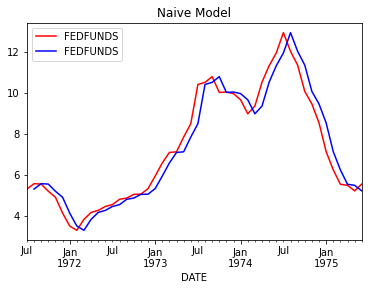

In [68]:
#visualization of the naive model vs actual fed funds rate
fig, ax = plt.subplots()
train[0:48].plot(ax=ax, c='r', label='Original')
naive[0:48].plot(ax=ax, c='b', label='Shifted')
ax.set_title('Naive Model')
ax.legend();

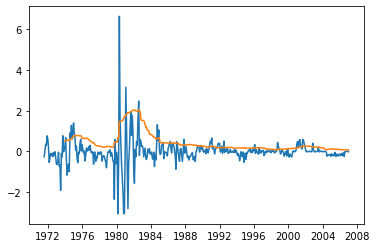

In [69]:
#Graphing the residuals of the Naive model, as we can see residuals spike during the high volatility of the late 70's
#early 80's
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

In [70]:
#Baseline RMSE for the naive model
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

0.6340657983361966

The RMSE value of .634 indicates that our predicted interest rates were off by .634 percentage points versus the actual interest rate level for the training data set. 

## Random Walk Model

In [71]:
#Using the Random Walk Model as our first simple model
RW_model = ARIMA(train, order=(0, 1, 0), freq='MS').fit()

# We put a typ='levels' to convert our predictions and remove the differencing performed.
RW_model_preds = RW_model.predict(typ='levels')
np.sqrt(mean_squared_error(train[1:], RW_model_preds[1:]))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.6340657983361887

In [72]:
#Using the Random Walk Model that uses the difference of the difference
RW2_model = ARIMA(train, order=(0, 2, 0), freq='MS').fit()

RW2_model_preds = RW2_model.predict(typ='levels')
np.sqrt(mean_squared_error(train[1:], RW2_model_preds[1:]))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.705413886573266

In [73]:
#Resetting the index to allow the for loop below to work
train_with_ind = train.reset_index()

In [74]:
##Time based cross validation against validation set (RW_model)
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.1309232359620225
1.5334481994125824
4.937945201893335
0.6587899705916243
3.2145700433153235


In [75]:
mean_RMSE_RW = (7.1309232359620225+
1.5334481994125824+
4.937945201893335+
0.6587899705916243+
3.2145700433153235) / 5
mean_RMSE_RW

3.4951353302349775

In [76]:
##Time based cross validation against validation set (RW2_model)
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 2, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

5.7642398030190405
6.36194706237021
4.5460896350590865
2.896737114347015
18.345251947533704


In [77]:
mean_RMSE_RW2 = (5.7642398030190405+
6.36194706237021+
4.5460896350590865+
2.896737114347015+
18.345251947533704) / 5
mean_RMSE_RW2

7.582853112465811

In [78]:
print(f'Random Walk AIC: {RW_model.aic}')
print(f'Random Walk 2  AIC: {RW2_model.aic}')

Random Walk AIC: 822.762260190724
Random Walk 2  AIC: 900.813007185475


As we can see above, The Random Walk Model with one differencing performs better against the Random Walk Model with two levels of differencing. RW_model has a lower Root Mean Squared Error against the training set, a lower Root Mean Squared Error against the validation set, and the model has a lower AIC (Akaike information criterion) score versus the RW2_model. The RMSE value of .634 indicates that our predicted interest rates were off by .634 percentage points versus the actual interest rate level for the training data set. The summary statistics for the RW_model can be seen below.


In [79]:
RW_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  427
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -410.381
Date:                Fri, 26 Aug 2022   AIC                            822.762
Time:                        10:28:47   BIC                            826.817
Sample:                    07-01-1971   HQIC                           824.364
                         - 01-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4020      0.007     61.590      0.000       0.389       0.415
===================================================================================
Ljung-Box (L1) (Q):                  67.85   Jarque-Bera (JB):             20372.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -2.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Auto-Regressive Model

In [395]:
##Using the AR Model with an order term of 1
AR_model = ARIMA(train, order=(1, 1, 0), freq='MS').fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
AR_model_preds = AR_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, AR_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.635369009803105

#Testing AR model with order term from 9 to 16 given the number of statistically significant data points on the PACF. 

In [396]:
AR9_model = ARIMA(train, order=(9, 1, 0), freq='MS').fit()

AR9_model_preds = AR9_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, AR9_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.6034465747965999

In [397]:
AR10_model = ARIMA(train, order=(10, 1, 0), freq='MS').fit()

AR10_model_preds = AR10_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, AR10_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.5991838153291951

In [398]:
AR11_model = ARIMA(train, order=(11, 1, 0), freq='MS').fit()

AR11_model_preds = AR11_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, AR11_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.5972336784711703

In [399]:
AR12_model = ARIMA(train, order=(12, 1, 0), freq='MS').fit()

AR12_model_preds = AR12_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, AR12_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.5971633827339382

In [400]:
AR13_model = ARIMA(train, order=(13, 1, 0), freq='MS').fit()

AR13_model_preds = AR13_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, AR13_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.5893041442942224

In [401]:
AR14_model = ARIMA(train, order=(14, 1, 0), freq='MS').fit()

AR14_model_preds = AR14_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, AR14_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.5892921601261029

In [402]:
AR15_model = ARIMA(train, order=(15, 1, 0), freq='MS').fit()

AR15_model_preds = AR15_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, AR15_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.5875037162930922

In [403]:
AR16_model = ARIMA(train, order=(16, 1, 0), freq='MS').fit()

AR16_model_preds = AR16_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, AR16_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.5858620038452607

In [406]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.090901982065298
1.5004575842526378
4.93229917233943
0.6861989698476272
2.9408238782165044


In [407]:
(7.090901982065298+
1.5004575842526378+
4.93229917233943+
0.6861989698476272+
2.9408238782165044)/5

3.4301363173442994

In [408]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(9, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.170816297254164
1.4462456155453534
4.930405384868989
0.7439845713642111
3.187216068042605


In [409]:
(7.170816297254164+
1.4462456155453534+
4.930405384868989+
0.7439845713642111+
3.187216068042605)/5

3.4957335874150646

In [410]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(10, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.15823195975463
1.630291887473498
4.668305879085297
0.5627039571754315
3.242742816631373


In [411]:
(7.15823195975463+
1.630291887473498+
4.668305879085297+
0.5627039571754315+
3.242742816631373)/5

3.452455300024046

In [412]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(11, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.142028269843377
1.8325591631020504
4.492189634435521
0.4819751462344955
3.2650213152886645


In [413]:
(7.142028269843377+
1.8325591631020504+
4.492189634435521+
0.4819751462344955+
3.2650213152886645)/5

3.442754705780821

In [414]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(12, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.157202873000472
1.8989044748044492
4.447602988110701
0.4710524017206157
3.269122791564643


In [415]:
(7.157202873000472+
1.8989044748044492+
4.447602988110701+
0.4710524017206157+
3.269122791564643)/5

3.4487771058401764

In [416]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(13, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.182905590588519
1.4292408115294712
4.855981172053124
0.6894885841926405
3.281114933483525


In [417]:
(7.182905590588519+
1.4292408115294712+
4.855981172053124+
0.6894885841926405+
3.281114933483525)/5

3.4877462183694554

In [418]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(14, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.1415200516515
1.406711200605704
4.867718739640286
0.7037801544703536
3.282677974639516


In [419]:
(7.1415200516515+
1.406711200605704+
4.867718739640286+
0.7037801544703536+
3.282677974639516)/5

3.4804816242014716

In [420]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(15, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.127820318430714
1.4881304797388901
5.140338471060639
0.9564252391798598
3.3000959789625015


In [421]:
(7.127820318430714+
1.4881304797388901+
5.140338471060639+
0.9564252391798598+
3.3000959789625015)/5

3.6025620974745207

In [422]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(16, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.163237990947649
1.7747730149201002
5.465853341403623
1.2272117399118965
3.368382806425109


In [423]:
(7.163237990947649+
1.7747730149201002+
5.465853341403623+
1.2272117399118965+
3.368382806425109)/5

3.7998917787216753

In [404]:
print(f'AR Model AIC: {AR_model.aic}')
print(f'AR9 Model AIC: {AR9_model.aic}')
print(f'AR10 Model AIC: {AR10_model.aic}' )
print(f'AR11 Model AIC: {AR11_model.aic}')
print(f'AR12 Model AIC: {AR12_model.aic}' )
print(f'AR13 Model AIC: {AR13_model.aic}')
print(f'AR14 Model AIC: {AR14_model.aic}' )
print(f'AR15 Model AIC: {AR15_model.aic}')
print(f'AR16 Model AIC: {AR16_model.aic}' )

AR Model AIC: 751.5604437572325
AR9 Model AIC: 714.9436371333101
AR10 Model AIC: 709.6646843823629
AR11 Model AIC: 708.3139489079034
AR12 Model AIC: 710.1929973082306
AR13 Model AIC: 698.5758353447825
AR14 Model AIC: 700.5548202966461
AR15 Model AIC: 699.4317562112791
AR16 Model AIC: 698.5570825539276


As we can see in the iterations above there is no one model that is best in all three metrics. But, given the above information, we can still determine the likely best model. The AR model with an order term of 15 (AR15_model) appears to be the best model as it ranks solidly in the time based cross validation, third in AIC score, and second on RMSE on the training data. Therefore, going forward our AR order term will be 15.

In [426]:
AR15_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  427
Model:                ARIMA(15, 1, 0)   Log Likelihood                -333.716
Date:                Tue, 23 Aug 2022   AIC                            699.432
Time:                        11:08:27   BIC                            764.303
Sample:                    07-01-1971   HQIC                           725.057
                         - 01-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4512      0.029     15.615      0.000       0.395       0.508
ar.L2         -0.1264      0.042     -2.998      0.003      -0.209      -0.044
ar.L3         -0.0154      0.042     -0.369      0.712      -0.098       0.067
ar.L4         -0.1059      0.051     -2.061      0.039      -0.207      -0.005
ar.L5          0.0016      0.022      0.075      0.940      -0.041       0.045
ar.L6          0.0255      0.036      0.700      0.484      -0.046       0.097
ar.L7         -0.1961      0.041     -4.746      0.000      -0.277      -0.115
ar.L8          0.1668      0.055      3.052      0.002       0.060       0.274
ar.L9          0.1454      0.035      4.138      0.000       0.077       0.214
ar.L10        -0.0824      0.045     -1.845      0.065      -0.170       0.005
ar.L11        -0.0481      0.044     -1.084      0.278      -0.135       0.039
ar.L12        -0.0927      0.036     -2.546      0.011      -0.164      -0.021
ar.L13         0.1819      0.058      3.147      0.002       0.069       0.295
ar.L14        -0.0311      0.053     -0.585      0.559      -0.135       0.073
ar.L15         0.0844      0.039      2.156      0.031       0.008       0.161
sigma2         0.2794      0.010     28.637      0.000       0.260       0.299
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             33566.16
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                            -3.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Moving Average Model

In [427]:
##Using the MA Model with an order term of 1
MA_model= ARIMA(train, order=(0, 1, 1)).fit()
MA_model_preds = MA_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, MA_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.6280104388421925

#Testing MA model with order term from 9 to 13 given the number of statistically significant data points on the ACF.

In [428]:
MA9_model= ARIMA(train, order=(0, 1, 9)).fit()
MA9_model_preds = MA9_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, MA9_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.597636411748908

In [429]:
MA10_model= ARIMA(train, order=(0, 1, 10)).fit()
MA10_model_preds = MA10_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, MA10_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.5916571425174637

In [430]:
MA11_model= ARIMA(train, order=(0, 1, 11)).fit()
MA11_model_preds = MA11_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, MA11_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.5910784218575565

In [431]:
MA12_model= ARIMA(train, order=(0, 1, 12)).fit()
MA12_model_preds = MA12_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, MA12_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.5899882003247853

In [432]:
MA13_model= ARIMA(train, order=(0, 1, 13)).fit()
MA13_model_preds = MA13_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, MA13_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.5899826839668543

In [434]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.184116820338985
1.5158379384527565
4.859445323085306
0.631229271141934
3.0877096889137037


In [435]:
(7.184116820338985+
1.5158379384527565+
4.859445323085306+
0.631229271141934+
3.0877096889137037)/5

3.4556678083865373

In [436]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 9)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.146315055539711
1.4524743427049371
4.776637327589403
0.6492355467471695
3.2422753438990664


In [437]:
(7.146315055539711+
1.4524743427049371+
4.776637327589403+
0.6492355467471695+
3.2422753438990664)/5

3.453387523296057

In [438]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 10)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.148894086241528
1.4422739945171064
5.127040884515948
0.8961933572019202
3.1758475372734143


In [439]:
(7.148894086241528+
1.4422739945171064+
5.127040884515948+
0.8961933572019202+
3.1758475372734143)/5

3.558049971949983

In [440]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 11)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

7.128300066686756
1.4490666203696856
5.242756277020849
1.0156886345153049
3.1414093604803983


In [441]:
(7.128300066686756+
1.4490666203696856+
5.242756277020849+
1.0156886345153049+
3.1414093604803983)/5

3.595444191814599

In [442]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 12)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7.336054454672714
1.4344087318147505
5.013900918340773
0.8336043310409692
3.221580264569262


In [443]:
(7.336054454672714+
1.4344087318147505+
5.013900918340773+
0.8336043310409692+
3.221580264569262)/5

3.567909740087694

In [444]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 13)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7.397726267506017
1.4408345279784094
5.007877668800189
0.8411396055415314
3.226041623176569


In [445]:
(7.397726267506017+
1.4408345279784094+
5.007877668800189+
0.8411396055415314+
3.226041623176569)/5

3.582723938600543

In [433]:
print(f'MA Model AIC: {MA_model.aic}')
print(f'MA9 Model AIC: {MA9_model.aic}')
print(f'MA10 Model AIC: {MA10_model.aic}' )
print(f'MA11 Model AIC: {MA11_model.aic}')
print(f'MA12 Model AIC: {MA12_model.aic}' )
print(f'MA13 Model AIC: {MA13_model.aic}')

MA Model AIC: 739.7107190799738
MA9 Model AIC: 705.2364895451997
MA10 Model AIC: 696.9211296768577
MA11 Model AIC: 697.9302778056718
MA12 Model AIC: 697.9034848378377
MA13 Model AIC: 699.8888534967257


As we can see in the iterations above there is no one model that is best in all three metrics. But, given the above information, we can still determine the likely best model. The MA model with an order term of 12 (MA12_model) appears to be the best model as it ranks third best in RMSE on time based cross validation as well as having the second lowest AIC score and RMSE on the training data. Therefore, going forward our MA order term will be 12.

In [446]:
MA12_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  427
Model:                ARIMA(0, 1, 12)   Log Likelihood                -335.952
Date:                Tue, 23 Aug 2022   AIC                            697.903
Time:                        11:14:40   BIC                            750.611
Sample:                    07-01-1971   HQIC                           718.724
                         - 01-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4512      0.032     14.217      0.000       0.389       0.513
ma.L2          0.0835      0.042      1.973      0.049       0.001       0.166
ma.L3         -0.0394      0.040     -0.985      0.324      -0.118       0.039
ma.L4         -0.1300      0.048     -2.706      0.007      -0.224      -0.036
ma.L5         -0.1185      0.039     -3.030      0.002      -0.195      -0.042
ma.L6         -0.0753      0.031     -2.418      0.016      -0.136      -0.014
ma.L7         -0.2317      0.040     -5.810      0.000      -0.310      -0.154
ma.L8          0.0535      0.040      1.331      0.183      -0.025       0.132
ma.L9          0.3455      0.044      7.915      0.000       0.260       0.431
ma.L10         0.1776      0.044      3.997      0.000       0.091       0.265
ma.L11         0.0254      0.043      0.594      0.553      -0.058       0.109
ma.L12        -0.0766      0.031     -2.462      0.014      -0.138      -0.016
sigma2         0.2823      0.009     31.083      0.000       0.264       0.300
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             32970.05
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                            -2.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA Model

Within the ARIMA model we will add the optimized AR and MA order terms described above. 

In [41]:
ARIMA_model = ARIMA(train, order=(15, 1, 12)).fit()
ARIMA_model_preds = ARIMA_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, ARIMA_model_preds))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mycha\anaconda3\e

0.5725592157399726

In [452]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(15, 1, 12)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7.8605734855776666


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1.482428968132855


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5.112432861137659


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.7102212607927086


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3.131153383910845


In [453]:
(7.8605734855776666+
1.482428968132855+
5.112432861137659+
0.7102212607927086+
3.131153383910845)/5

3.659361991910347

In [42]:
ARIMA_model.aic

693.8304080969922

As we can see above, the ARIMA model that takes in the optimal AR and MA parameters shows slight improvement in all metrics except the time based cross validation test, where it ranks roughly average versus the best AR and MA model.

In [43]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  427
Model:               ARIMA(15, 1, 12)   Log Likelihood                -318.915
Date:                Tue, 23 Aug 2022   AIC                            693.830
Time:                        17:34:47   BIC                            807.355
Sample:                    07-01-1971   HQIC                           738.675
                         - 01-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3261      1.335      0.244      0.807      -2.291       2.943
ar.L2          0.2441      0.396      0.616      0.538      -0.533       1.021
ar.L3         -0.0973      0.572     -0.170      0.865      -1.218       1.024
ar.L4         -0.3486      0.198     -1.757      0.079      -0.737       0.040
ar.L5         -0.0743      0.434     -0.171      0.864      -0.925       0.776
ar.L6         -0.0451      0.279     -0.162      0.872      -0.593       0.502
ar.L7         -0.0009      0.145     -0.006      0.995      -0.285       0.283
ar.L8         -0.0988      0.164     -0.602      0.547      -0.420       0.223
ar.L9         -0.0933      0.179     -0.522      0.602      -0.444       0.257
ar.L10         0.0309      0.183      0.169      0.866      -0.327       0.389
ar.L11         0.3040      0.138      2.205      0.027       0.034       0.574
ar.L12        -0.3699      0.457     -0.809      0.419      -1.266       0.526
ar.L13         0.2632      0.450      0.585      0.558      -0.618       1.145
ar.L14         0.0814      0.338      0.241      0.810      -0.581       0.744
ar.L15         0.0362      0.210      0.172      0.863      -0.376       0.448
ma.L1          0.1066      1.340      0.080      0.937      -2.519       2.732
ma.L2         -0.3029      0.433     -0.700      0.484      -1.151       0.545
ma.L3         -0.0825      0.589     -0.140      0.889      -1.238       1.073
ma.L4          0.2765      0.264      1.047      0.295      -0.241       0.794
ma.L5          0.2475      0.351      0.704      0.481      -0.441       0.936
ma.L6          0.1676      0.475      0.353      0.724      -0.763       1.099
ma.L7         -0.1814      0.300     -0.605      0.545      -0.769       0.406
ma.L8          0.1488      0.352      0.422      0.673      -0.542       0.839
ma.L9          0.4602      0.196      2.348      0.019       0.076       0.844
ma.L10        -0.0282      0.627     -0.045      0.964      -1.258       1.201
ma.L11        -0.5797      0.212     -2.730      0.006      -0.996      -0.163
ma.L12         0.0936      0.848      0.110      0.912      -1.569       1.756
sigma2         0.2546      0.029      8.864      0.000       0.198       0.311
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             30799.99
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -2.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMA Model

The SARIMA Model takes in the same parameters as the previously discussed ARIMA Model, but it also takes in another factor- Seasonality. Analyzing the ACF in the Capstone_Preprocessing_EDA_Final notebook you can see that there is no clear seasonal trend but when looking at the Seasonal Decomposition graph there does appear to be a crash and then a spike roughly every three years. We will use the SARIMA model with a seasonal order term of three, six (double), and nine (triple) years and find the best model determined by the RMSE and AIC score.


In [457]:
#Iterating through the SARIMA model with a range of 0-2 for order terms and 36 month seasonal adjustment 
#(36 month is seasonal cyclicality shown in Seasonal Decompostion in EDA notebook)
p = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 36) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 36)
SARIMAX: (0, 1, 0) x (0, 1, 1, 36)
SARIMAX: (0, 1, 0) x (0, 1, 2, 36)
SARIMAX: (0, 1, 0) x (1, 1, 0, 36)
SARIMAX: (0, 1, 0) x (1, 1, 1, 36)
SARIMAX: (0, 1, 0) x (1, 1, 2, 36)
SARIMAX: (0, 1, 0) x (2, 1, 0, 36)
SARIMAX: (0, 1, 0) x (2, 1, 1, 36)
SARIMAX: (0, 1, 0) x (2, 1, 2, 36)
SARIMAX: (0, 1, 1) x (0, 1, 0, 36)
SARIMAX: (0, 1, 1) x (0, 1, 1, 36)
SARIMAX: (0, 1, 1) x (0, 1, 2, 36)
SARIMAX: (0, 1, 1) x (1, 1, 0, 36)
SARIMAX: (0, 1, 1) x (1, 1, 1, 36)
SARIMAX: (0, 1, 1) x (1, 1, 2, 36)
SARIMAX: (0, 1, 1) x (2, 1, 0, 36)
SARIMAX: (0, 1, 1) x (2, 1, 1, 36)
SARIMAX: (0, 1, 1) x (2, 1, 2, 36)
SARIMAX: (0, 1, 2) x (0, 1, 0, 36)
SARIMAX: (0, 1, 2) x (0, 1, 1, 36)
SARIMAX: (0, 1, 2) x (0, 1, 2, 36)
SARIMAX: (0, 1, 2) x (1, 1, 0, 36)
SARIMAX: (0, 1, 2) x (1, 1, 1, 36)
SARIMAX: (0, 1, 2) x (1, 1, 2, 36)
SARIMAX: (0, 1, 2) x (2, 1, 0, 36)
SARIMAX: (0, 1, 2) x (2, 1, 1, 36)
SARIMAX: (0, 1, 2) x (2, 1, 2, 36)
SARIMAX: (1, 1, 0) 

In [458]:
#Iterating through the SARIMA model with a range of 0-2 for order terms and 36 month seasonal adjustment 
#(36 month is seasonal cyclicality shown in Seasonal Decompostion in EDA notebook)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            #results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 0, 36) - AIC:1049.033879910419


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 1, 36) - AIC:768.1091050219326


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 2, 36) - AIC:602.7462577144815


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 0, 36) - AIC:876.0151211827905


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 1, 36) - AIC:772.5991983902655


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 2, 36) - AIC:540.0557189793092


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 0, 36) - AIC:639.0302085046445


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 1, 36) - AIC:631.0761532418358


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 2, 36) - AIC:615.1388259202229


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 0, 36) - AIC:980.3326523240537


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 1, 36) - AIC:697.4703740046613


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 2, 36) - AIC:515.1022676298779


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 0, 36) - AIC:808.0162393051514


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 1, 36) - AIC:697.1888837959848


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 2, 36) - AIC:439.4721478269279


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 0, 36) - AIC:543.2009875611166


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 1, 36) - AIC:538.3662640088163


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 2, 36) - AIC:520.459600405657


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(0, 1, 0, 36) - AIC:978.8397884501302


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(0, 1, 1, 36) - AIC:694.5872877186616


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(0, 1, 2, 36) - AIC:503.1016624570821


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(1, 1, 0, 36) - AIC:806.9661984446268


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(1, 1, 1, 36) - AIC:694.7678447000858


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(1, 1, 2, 36) - AIC:418.2127773120422


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(2, 1, 0, 36) - AIC:536.9361791929437


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(2, 1, 1, 36) - AIC:529.7977302357301


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(2, 1, 2, 36) - AIC:506.0883384252536


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(0, 1, 0, 36) - AIC:988.7734011729158


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(0, 1, 1, 36) - AIC:707.5929272443193


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(0, 1, 2, 36) - AIC:526.3868315163224


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(1, 1, 0, 36) - AIC:812.019214489285


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(1, 1, 1, 36) - AIC:711.7872679149621


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(1, 1, 2, 36) - AIC:443.27775294637524


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(2, 1, 0, 36) - AIC:549.339851326099


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(2, 1, 1, 36) - AIC:541.7957358461176


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(2, 1, 2, 36) - AIC:536.1039959794971


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(0, 1, 0, 36) - AIC:981.3503735673344


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(0, 1, 1, 36) - AIC:697.9682816169701


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(0, 1, 2, 36) - AIC:513.3227233495129


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 0, 36) - AIC:805.3560423023916


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 1, 36) - AIC:698.8179146712723


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 2, 36) - AIC:431.8926392572707


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(2, 1, 0, 36) - AIC:536.6280660226926


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(2, 1, 1, 36) - AIC:530.1202928468616


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(2, 1, 2, 36) - AIC:518.9700020761434


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(0, 1, 0, 36) - AIC:981.5199469350944


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(0, 1, 1, 36) - AIC:697.0894486578701


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(0, 1, 2, 36) - AIC:511.3958920790423


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(1, 1, 0, 36) - AIC:804.5162612686148


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(1, 1, 1, 36) - AIC:696.1189592129848


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(1, 1, 2, 36) - AIC:419.77512120149794


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(2, 1, 0, 36) - AIC:536.8989831113752


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(2, 1, 1, 36) - AIC:529.1316395575229


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(2, 1, 2, 36) - AIC:508.06812279877033


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(0, 1, 0, 36) - AIC:979.3755801125955


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(0, 1, 1, 36) - AIC:695.8979877423126


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(0, 1, 2, 36) - AIC:510.4580419043729


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(1, 1, 0, 36) - AIC:799.8607579573872


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(1, 1, 1, 36) - AIC:697.0968824462464


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(1, 1, 2, 36) - AIC:433.3523148670306


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(2, 1, 0, 36) - AIC:526.9433480298164


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(2, 1, 1, 36) - AIC:520.189607501947


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(2, 1, 2, 36) - AIC:515.9092929899896


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(0, 1, 0, 36) - AIC:978.8696520719966


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(0, 1, 1, 36) - AIC:692.1661714983226


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(0, 1, 2, 36) - AIC:507.31565279319364


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(1, 1, 0, 36) - AIC:795.7128225867241


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(1, 1, 1, 36) - AIC:697.9726290756314


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(1, 1, 2, 36) - AIC:432.28686473545946


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(2, 1, 0, 36) - AIC:528.0096979757769


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(2, 1, 1, 36) - AIC:521.3704201389849


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(2, 1, 2, 36) - AIC:517.7439225298539


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(0, 1, 0, 36) - AIC:978.3729673597493


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(0, 1, 1, 36) - AIC:690.8770521773207


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(0, 1, 2, 36) - AIC:484.9811667169828


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(1, 1, 0, 36) - AIC:797.7120398962172


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(1, 1, 1, 36) - AIC:694.7878372992523


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(1, 1, 2, 36) - AIC:421.5320643448471


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(2, 1, 0, 36) - AIC:529.4484760900681


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(2, 1, 1, 36) - AIC:521.156648637131


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(2, 1, 2, 36) - AIC:506.75241486893276


In [46]:
#Using parameters with lowest AIC to create a model 
mod_1=SARIMAX(train,
                         order=(0,1,2),
                         seasonal_order=(2,1,0,36),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
results_1 = mod_1.fit()

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [47]:
#Train RMSE
results_1_preds = results_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, results_1_preds))

0.7411193177458861

In [50]:
#Validation Set RMSE
preds = results_1.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
true = train_with_ind.iloc[val_ind, -1]
print(np.sqrt(mean_squared_error(true, preds)))

1.385806406135287


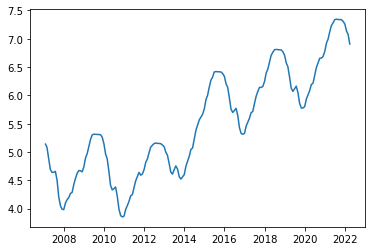

In [52]:
#Graphing Test predictions
y_hat_SARIMA = results_1.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_SARIMA);

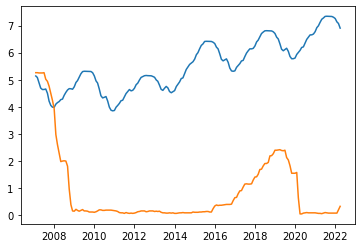

In [53]:
#Graphing test predictions vs test actual
fig, ax = plt.subplots()
ax.plot(y_hat_SARIMA)
ax.plot(test);

In [54]:
results_1.aic

536.9361791929437

In [13]:
#Iterating through the SARIMA model with a range of 0-2 for order terms and 72 month seasonal adjustment 
#(72 month is 2x seasonal cyclicality shown in Seasonal Decompostion in EDA notebook)
p = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 72) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 72)
SARIMAX: (0, 1, 0) x (0, 1, 1, 72)
SARIMAX: (0, 1, 0) x (0, 1, 2, 72)
SARIMAX: (0, 1, 0) x (1, 1, 0, 72)
SARIMAX: (0, 1, 0) x (1, 1, 1, 72)
SARIMAX: (0, 1, 0) x (1, 1, 2, 72)
SARIMAX: (0, 1, 0) x (2, 1, 0, 72)
SARIMAX: (0, 1, 0) x (2, 1, 1, 72)
SARIMAX: (0, 1, 0) x (2, 1, 2, 72)
SARIMAX: (0, 1, 1) x (0, 1, 0, 72)
SARIMAX: (0, 1, 1) x (0, 1, 1, 72)
SARIMAX: (0, 1, 1) x (0, 1, 2, 72)
SARIMAX: (0, 1, 1) x (1, 1, 0, 72)
SARIMAX: (0, 1, 1) x (1, 1, 1, 72)
SARIMAX: (0, 1, 1) x (1, 1, 2, 72)
SARIMAX: (0, 1, 1) x (2, 1, 0, 72)
SARIMAX: (0, 1, 1) x (2, 1, 1, 72)
SARIMAX: (0, 1, 1) x (2, 1, 2, 72)
SARIMAX: (0, 1, 2) x (0, 1, 0, 72)
SARIMAX: (0, 1, 2) x (0, 1, 1, 72)
SARIMAX: (0, 1, 2) x (0, 1, 2, 72)
SARIMAX: (0, 1, 2) x (1, 1, 0, 72)
SARIMAX: (0, 1, 2) x (1, 1, 1, 72)
SARIMAX: (0, 1, 2) x (1, 1, 2, 72)
SARIMAX: (0, 1, 2) x (2, 1, 0, 72)
SARIMAX: (0, 1, 2) x (2, 1, 1, 72)
SARIMAX: (0, 1, 2) x (2, 1, 2, 72)
SARIMAX: (1, 1, 0) 

In [466]:
#Iterating through the SARIMA model with a range of 0-2 for order terms and 72 month seasonal adjustment 
#(72 month is 2x seasonal cyclicality shown in Seasonal Decompostion in EDA notebook)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            #results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 0, 72) - AIC:983.1810432728468


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 1, 72) - AIC:434.8979159330066


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 1, 2, 72) - AIC:78.78580378922527


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 0, 72) - AIC:484.9368481547841


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 1, 72) - AIC:403.245972378475


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 2, 72) - AIC:80.71169675803988


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 0, 72) - AIC:71.78637764660138


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 1, 72) - AIC:68.60223271100926


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 2, 72) - AIC:68.78789818836147


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 0, 72) - AIC:912.3107636400694


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 1, 72) - AIC:375.4108451300679


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 2, 72) - AIC:56.72078851525987


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 0, 72) - AIC:424.86637389219493


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 1, 72) - AIC:353.8611615042504


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 2, 72) - AIC:58.626817599668954


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 0, 72) - AIC:50.392653635671095


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 1, 72) - AIC:46.480653289765804


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 2, 72) - AIC:46.52338293807351


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(0, 1, 0, 72) - AIC:907.3011725173106


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(0, 1, 1, 72) - AIC:376.35325929440967


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(0, 1, 2, 72) - AIC:52.51680830108512


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(1, 1, 0, 72) - AIC:426.6676298358109


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(1, 1, 1, 72) - AIC:355.2913788889053


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(1, 1, 2, 72) - AIC:54.48067216296268


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(2, 1, 0, 72) - AIC:45.63372329288255


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(2, 1, 1, 72) - AIC:40.929973824008115


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(2, 1, 2, 72) - AIC:41.089943475541766


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(0, 1, 0, 72) - AIC:918.896776922031


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(0, 1, 1, 72) - AIC:392.37761338323975


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(0, 1, 2, 72) - AIC:51.179893949619824


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(1, 1, 0, 72) - AIC:438.7227341275098


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(1, 1, 1, 72) - AIC:359.3599142519946


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(1, 1, 2, 72) - AIC:53.12485953020436


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(2, 1, 0, 72) - AIC:42.97789925136421


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(2, 1, 1, 72) - AIC:38.811414017739516


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(2, 1, 2, 72) - AIC:40.759070853308245


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(0, 1, 0, 72) - AIC:910.9606310137601


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(0, 1, 1, 72) - AIC:376.65292237305886


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(0, 1, 2, 72) - AIC:51.72187967898748


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 0, 72) - AIC:425.82745127973874


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 1, 72) - AIC:355.8197047042994


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(1, 1, 2, 72) - AIC:53.65774359005236


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(2, 1, 0, 72) - AIC:44.27468924790714


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(2, 1, 1, 72) - AIC:40.16389303917432


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 1)x(2, 1, 2, 72) - AIC:41.60302598499769


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(0, 1, 0, 72) - AIC:911.3477641392884


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(0, 1, 1, 72) - AIC:376.38442173675685


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(0, 1, 2, 72) - AIC:52.80161903682262


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(1, 1, 0, 72) - AIC:427.702807493538


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(1, 1, 1, 72) - AIC:355.89859801441685


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(1, 1, 2, 72) - AIC:54.732315705568254


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(2, 1, 0, 72) - AIC:45.30830141124905


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(2, 1, 1, 72) - AIC:40.8671707129288


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(2, 1, 2, 72) - AIC:42.62264934350813


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(0, 1, 0, 72) - AIC:905.9145057841275


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(0, 1, 1, 72) - AIC:383.32562930319745


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(0, 1, 2, 72) - AIC:52.38019549903968


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(1, 1, 0, 72) - AIC:429.6841344722761


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(1, 1, 1, 72) - AIC:357.35018714989354


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(1, 1, 2, 72) - AIC:54.34725255697387


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(2, 1, 0, 72) - AIC:43.78586981534528


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(2, 1, 1, 72) - AIC:39.56389379657762


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 0)x(2, 1, 2, 72) - AIC:41.46182377227474


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(0, 1, 0, 72) - AIC:899.1574615341549


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(0, 1, 1, 72) - AIC:378.3784411008404


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(0, 1, 2, 72) - AIC:52.14514022744243


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(1, 1, 0, 72) - AIC:427.0004913419697


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(1, 1, 1, 72) - AIC:356.26213243688375


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(1, 1, 2, 72) - AIC:54.13258326324876


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(2, 1, 0, 72) - AIC:43.312325079587595


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(2, 1, 1, 72) - AIC:39.99358935593951


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(2, 1, 2, 72) - AIC:41.75548569366884


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(0, 1, 0, 72) - AIC:899.1160265735061


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(0, 1, 1, 72) - AIC:379.4627768669768


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(0, 1, 2, 72) - AIC:54.1496923280304


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(1, 1, 0, 72) - AIC:428.51959943383076


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(1, 1, 1, 72) - AIC:357.65462853471723


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(1, 1, 2, 72) - AIC:56.09617194225605


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(2, 1, 0, 72) - AIC:45.296428429970156


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(2, 1, 1, 72) - AIC:41.967385290591544


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(2, 1, 2, 72) - AIC:44.014882751338476


In [ ]:
#Iteration with lowest AIC
ARIMA(1, 1, 0)x(2, 1, 1, 72) - AIC:38.811414017739516

In [80]:
#Using parameters with lowest AIC to create a model 
mod_2=SARIMAX(train,
                         order=(1,1,0),
                         seasonal_order=(2,1,1,72),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
results_2 = mod_2.fit()

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [81]:
#Train RMSE
results_2_preds = results_2.predict(start=train.index[0],end=train.index[-1], typ='levels')
np.sqrt(mean_squared_error(train, results_2_preds))

0.8762887312106934

In [105]:
#Validation Set RMSE
preds = results_2.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
true = train_with_ind.iloc[val_ind, -1]
print(np.sqrt(mean_squared_error(true, preds)))

0.17321877979554862


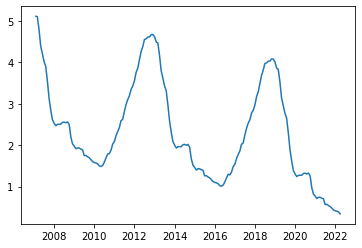

In [21]:
#Graphing test predictions
y_hat_SARIMA_2 = results_2.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_SARIMA_2);

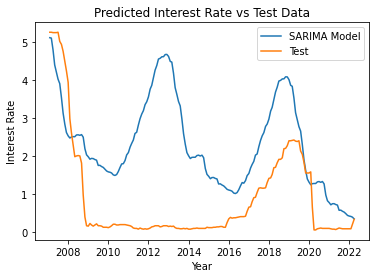

In [47]:
#Graphing test predictions vs test actual 
fig, ax = plt.subplots()
ax.plot(y_hat_SARIMA_2, label='SARIMA Model')
ax.plot(test, label='Test')
ax.set_ylabel('Interest Rate')
ax.set_xlabel('Year')
ax.set_title('Predicted Interest Rate vs Test Data')
plt.legend();

In [26]:
results_2.aic

38.811414017739516

In [46]:
#Iterating through the SARIMA model with a range of 0-2 for order terms and 108 month seasonal adjustment 
#(108 month is 3x seasonal cyclicality shown in Seasonal Decompostion in EDA notebook)
p = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 108) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 108)
SARIMAX: (0, 1, 0) x (0, 1, 1, 108)
SARIMAX: (0, 1, 0) x (0, 1, 2, 108)
SARIMAX: (0, 1, 0) x (1, 1, 0, 108)
SARIMAX: (0, 1, 0) x (1, 1, 1, 108)
SARIMAX: (0, 1, 0) x (1, 1, 2, 108)
SARIMAX: (0, 1, 0) x (2, 1, 0, 108)
SARIMAX: (0, 1, 0) x (2, 1, 1, 108)
SARIMAX: (0, 1, 0) x (2, 1, 2, 108)
SARIMAX: (0, 1, 1) x (0, 1, 0, 108)
SARIMAX: (0, 1, 1) x (0, 1, 1, 108)
SARIMAX: (0, 1, 1) x (0, 1, 2, 108)
SARIMAX: (0, 1, 1) x (1, 1, 0, 108)
SARIMAX: (0, 1, 1) x (1, 1, 1, 108)
SARIMAX: (0, 1, 1) x (1, 1, 2, 108)
SARIMAX: (0, 1, 1) x (2, 1, 0, 108)
SARIMAX: (0, 1, 1) x (2, 1, 1, 108)
SARIMAX: (0, 1, 1) x (2, 1, 2, 108)
SARIMAX: (0, 1, 2) x (0, 1, 0, 108)
SARIMAX: (0, 1, 2) x (0, 1, 1, 108)
SARIMAX: (0, 1, 2) x (0, 1, 2, 108)
SARIMAX: (0, 1, 2) x (1, 1, 0, 108)
SARIMAX: (0, 1, 2) x (1, 1, 1, 108)
SARIMAX: (0, 1, 2) x (1, 1, 2, 108)
SARIMAX: (0, 1, 2) x (2, 1, 0, 108)
SARIMAX: (0, 1, 2) x (2, 1, 1, 108)
SARIMAX: (0, 1, 2) x (2, 1, 

In [ ]:
#Iterating through the SARIMA model with a range of 0-2 for order terms and 108 month seasonal adjustment 
#(108 month is 3x seasonal cyclicality shown in Seasonal Decompostion in EDA notebook)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            #results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 0, 108) - AIC:837.9177325070377


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 1, 1, 108) - AIC:327.1460587593947


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [ ]:
#Iteration with lowest AIC
ARIMA(0, 1, 0)x(0, 1, 2, 108) - AIC:20.985734860236228

In [20]:
#Using parameters with lowest AIC to create a model 
mod_3=SARIMAX(train,
                         order=(0,1,0),
                         seasonal_order=(0,1,2,108),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
results_3 = mod_3.fit()

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [58]:
#Train RMSE
results_3_preds = results_3.predict(start=train.index[0],end=train.index[-1], typ='levels')
np.sqrt(mean_squared_error(train, results_3_preds))

0.9551760411853721

In [59]:
#Validation Set RMSE
preds = results_3.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
true = train_with_ind.iloc[val_ind, -1]
print(np.sqrt(mean_squared_error(true, preds)))

1.5491342423746703


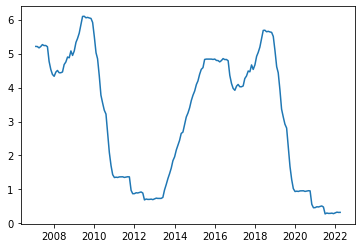

In [61]:
#Graphing test predictions
y_hat_SARIMA_3 = results_3.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_SARIMA_3);

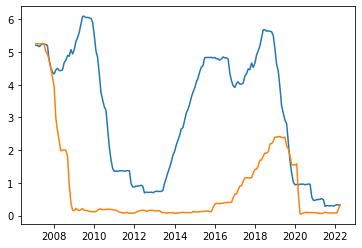

In [62]:
#Graphing test predictions vs test actual
fig, ax = plt.subplots()
ax.plot(y_hat_SARIMA_3)
ax.plot(test);

In [21]:
results_3.aic

20.985734860236228

In [15]:
#Trying to run the computationally expensive 72 month seasonal term with order terms up to 14.
p = q = range(0, 15)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 72) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 72)
SARIMAX: (0, 1, 0) x (0, 1, 1, 72)
SARIMAX: (0, 1, 0) x (0, 1, 2, 72)
SARIMAX: (0, 1, 0) x (0, 1, 3, 72)
SARIMAX: (0, 1, 0) x (0, 1, 4, 72)
SARIMAX: (0, 1, 0) x (0, 1, 5, 72)
SARIMAX: (0, 1, 0) x (0, 1, 6, 72)
SARIMAX: (0, 1, 0) x (0, 1, 7, 72)
SARIMAX: (0, 1, 0) x (0, 1, 8, 72)
SARIMAX: (0, 1, 0) x (0, 1, 9, 72)
SARIMAX: (0, 1, 0) x (0, 1, 10, 72)
SARIMAX: (0, 1, 0) x (0, 1, 11, 72)
SARIMAX: (0, 1, 0) x (0, 1, 12, 72)
SARIMAX: (0, 1, 0) x (0, 1, 13, 72)
SARIMAX: (0, 1, 0) x (0, 1, 14, 72)
SARIMAX: (0, 1, 0) x (1, 1, 0, 72)
SARIMAX: (0, 1, 0) x (1, 1, 1, 72)
SARIMAX: (0, 1, 0) x (1, 1, 2, 72)
SARIMAX: (0, 1, 0) x (1, 1, 3, 72)
SARIMAX: (0, 1, 0) x (1, 1, 4, 72)
SARIMAX: (0, 1, 0) x (1, 1, 5, 72)
SARIMAX: (0, 1, 0) x (1, 1, 6, 72)
SARIMAX: (0, 1, 0) x (1, 1, 7, 72)
SARIMAX: (0, 1, 0) x (1, 1, 8, 72)
SARIMAX: (0, 1, 0) x (1, 1, 9, 72)
SARIMAX: (0, 1, 0) x (1, 1, 10, 72)
SARIMAX: (0, 1, 0) x (1, 1, 11, 72)
SARIMAX: (0,

SARIMAX: (0, 1, 12) x (10, 1, 14, 72)
SARIMAX: (0, 1, 12) x (11, 1, 0, 72)
SARIMAX: (0, 1, 12) x (11, 1, 1, 72)
SARIMAX: (0, 1, 12) x (11, 1, 2, 72)
SARIMAX: (0, 1, 12) x (11, 1, 3, 72)
SARIMAX: (0, 1, 12) x (11, 1, 4, 72)
SARIMAX: (0, 1, 12) x (11, 1, 5, 72)
SARIMAX: (0, 1, 12) x (11, 1, 6, 72)
SARIMAX: (0, 1, 12) x (11, 1, 7, 72)
SARIMAX: (0, 1, 12) x (11, 1, 8, 72)
SARIMAX: (0, 1, 12) x (11, 1, 9, 72)
SARIMAX: (0, 1, 12) x (11, 1, 10, 72)
SARIMAX: (0, 1, 12) x (11, 1, 11, 72)
SARIMAX: (0, 1, 12) x (11, 1, 12, 72)
SARIMAX: (0, 1, 12) x (11, 1, 13, 72)
SARIMAX: (0, 1, 12) x (11, 1, 14, 72)
SARIMAX: (0, 1, 12) x (12, 1, 0, 72)
SARIMAX: (0, 1, 12) x (12, 1, 1, 72)
SARIMAX: (0, 1, 12) x (12, 1, 2, 72)
SARIMAX: (0, 1, 12) x (12, 1, 3, 72)
SARIMAX: (0, 1, 12) x (12, 1, 4, 72)
SARIMAX: (0, 1, 12) x (12, 1, 5, 72)
SARIMAX: (0, 1, 12) x (12, 1, 6, 72)
SARIMAX: (0, 1, 12) x (12, 1, 7, 72)
SARIMAX: (0, 1, 12) x (12, 1, 8, 72)
SARIMAX: (0, 1, 12) x (12, 1, 9, 72)
SARIMAX: (0, 1, 12) x (12, 1, 10

SARIMAX: (1, 1, 9) x (12, 1, 5, 72)
SARIMAX: (1, 1, 9) x (12, 1, 6, 72)
SARIMAX: (1, 1, 9) x (12, 1, 7, 72)
SARIMAX: (1, 1, 9) x (12, 1, 8, 72)
SARIMAX: (1, 1, 9) x (12, 1, 9, 72)
SARIMAX: (1, 1, 9) x (12, 1, 10, 72)
SARIMAX: (1, 1, 9) x (12, 1, 11, 72)
SARIMAX: (1, 1, 9) x (12, 1, 12, 72)
SARIMAX: (1, 1, 9) x (12, 1, 13, 72)
SARIMAX: (1, 1, 9) x (12, 1, 14, 72)
SARIMAX: (1, 1, 9) x (13, 1, 0, 72)
SARIMAX: (1, 1, 9) x (13, 1, 1, 72)
SARIMAX: (1, 1, 9) x (13, 1, 2, 72)
SARIMAX: (1, 1, 9) x (13, 1, 3, 72)
SARIMAX: (1, 1, 9) x (13, 1, 4, 72)
SARIMAX: (1, 1, 9) x (13, 1, 5, 72)
SARIMAX: (1, 1, 9) x (13, 1, 6, 72)
SARIMAX: (1, 1, 9) x (13, 1, 7, 72)
SARIMAX: (1, 1, 9) x (13, 1, 8, 72)
SARIMAX: (1, 1, 9) x (13, 1, 9, 72)
SARIMAX: (1, 1, 9) x (13, 1, 10, 72)
SARIMAX: (1, 1, 9) x (13, 1, 11, 72)
SARIMAX: (1, 1, 9) x (13, 1, 12, 72)
SARIMAX: (1, 1, 9) x (13, 1, 13, 72)
SARIMAX: (1, 1, 9) x (13, 1, 14, 72)
SARIMAX: (1, 1, 9) x (14, 1, 0, 72)
SARIMAX: (1, 1, 9) x (14, 1, 1, 72)
SARIMAX: (1, 1, 9)

SARIMAX: (2, 1, 8) x (7, 1, 13, 72)
SARIMAX: (2, 1, 8) x (7, 1, 14, 72)
SARIMAX: (2, 1, 8) x (8, 1, 0, 72)
SARIMAX: (2, 1, 8) x (8, 1, 1, 72)
SARIMAX: (2, 1, 8) x (8, 1, 2, 72)
SARIMAX: (2, 1, 8) x (8, 1, 3, 72)
SARIMAX: (2, 1, 8) x (8, 1, 4, 72)
SARIMAX: (2, 1, 8) x (8, 1, 5, 72)
SARIMAX: (2, 1, 8) x (8, 1, 6, 72)
SARIMAX: (2, 1, 8) x (8, 1, 7, 72)
SARIMAX: (2, 1, 8) x (8, 1, 8, 72)
SARIMAX: (2, 1, 8) x (8, 1, 9, 72)
SARIMAX: (2, 1, 8) x (8, 1, 10, 72)
SARIMAX: (2, 1, 8) x (8, 1, 11, 72)
SARIMAX: (2, 1, 8) x (8, 1, 12, 72)
SARIMAX: (2, 1, 8) x (8, 1, 13, 72)
SARIMAX: (2, 1, 8) x (8, 1, 14, 72)
SARIMAX: (2, 1, 8) x (9, 1, 0, 72)
SARIMAX: (2, 1, 8) x (9, 1, 1, 72)
SARIMAX: (2, 1, 8) x (9, 1, 2, 72)
SARIMAX: (2, 1, 8) x (9, 1, 3, 72)
SARIMAX: (2, 1, 8) x (9, 1, 4, 72)
SARIMAX: (2, 1, 8) x (9, 1, 5, 72)
SARIMAX: (2, 1, 8) x (9, 1, 6, 72)
SARIMAX: (2, 1, 8) x (9, 1, 7, 72)
SARIMAX: (2, 1, 8) x (9, 1, 8, 72)
SARIMAX: (2, 1, 8) x (9, 1, 9, 72)
SARIMAX: (2, 1, 8) x (9, 1, 10, 72)
SARIMAX: (2,

SARIMAX: (3, 1, 9) x (3, 1, 13, 72)
SARIMAX: (3, 1, 9) x (3, 1, 14, 72)
SARIMAX: (3, 1, 9) x (4, 1, 0, 72)
SARIMAX: (3, 1, 9) x (4, 1, 1, 72)
SARIMAX: (3, 1, 9) x (4, 1, 2, 72)
SARIMAX: (3, 1, 9) x (4, 1, 3, 72)
SARIMAX: (3, 1, 9) x (4, 1, 4, 72)
SARIMAX: (3, 1, 9) x (4, 1, 5, 72)
SARIMAX: (3, 1, 9) x (4, 1, 6, 72)
SARIMAX: (3, 1, 9) x (4, 1, 7, 72)
SARIMAX: (3, 1, 9) x (4, 1, 8, 72)
SARIMAX: (3, 1, 9) x (4, 1, 9, 72)
SARIMAX: (3, 1, 9) x (4, 1, 10, 72)
SARIMAX: (3, 1, 9) x (4, 1, 11, 72)
SARIMAX: (3, 1, 9) x (4, 1, 12, 72)
SARIMAX: (3, 1, 9) x (4, 1, 13, 72)
SARIMAX: (3, 1, 9) x (4, 1, 14, 72)
SARIMAX: (3, 1, 9) x (5, 1, 0, 72)
SARIMAX: (3, 1, 9) x (5, 1, 1, 72)
SARIMAX: (3, 1, 9) x (5, 1, 2, 72)
SARIMAX: (3, 1, 9) x (5, 1, 3, 72)
SARIMAX: (3, 1, 9) x (5, 1, 4, 72)
SARIMAX: (3, 1, 9) x (5, 1, 5, 72)
SARIMAX: (3, 1, 9) x (5, 1, 6, 72)
SARIMAX: (3, 1, 9) x (5, 1, 7, 72)
SARIMAX: (3, 1, 9) x (5, 1, 8, 72)
SARIMAX: (3, 1, 9) x (5, 1, 9, 72)
SARIMAX: (3, 1, 9) x (5, 1, 10, 72)
SARIMAX: (3,

SARIMAX: (4, 1, 1) x (13, 1, 14, 72)
SARIMAX: (4, 1, 1) x (14, 1, 0, 72)
SARIMAX: (4, 1, 1) x (14, 1, 1, 72)
SARIMAX: (4, 1, 1) x (14, 1, 2, 72)
SARIMAX: (4, 1, 1) x (14, 1, 3, 72)
SARIMAX: (4, 1, 1) x (14, 1, 4, 72)
SARIMAX: (4, 1, 1) x (14, 1, 5, 72)
SARIMAX: (4, 1, 1) x (14, 1, 6, 72)
SARIMAX: (4, 1, 1) x (14, 1, 7, 72)
SARIMAX: (4, 1, 1) x (14, 1, 8, 72)
SARIMAX: (4, 1, 1) x (14, 1, 9, 72)
SARIMAX: (4, 1, 1) x (14, 1, 10, 72)
SARIMAX: (4, 1, 1) x (14, 1, 11, 72)
SARIMAX: (4, 1, 1) x (14, 1, 12, 72)
SARIMAX: (4, 1, 1) x (14, 1, 13, 72)
SARIMAX: (4, 1, 1) x (14, 1, 14, 72)
SARIMAX: (4, 1, 2) x (0, 1, 0, 72)
SARIMAX: (4, 1, 2) x (0, 1, 1, 72)
SARIMAX: (4, 1, 2) x (0, 1, 2, 72)
SARIMAX: (4, 1, 2) x (0, 1, 3, 72)
SARIMAX: (4, 1, 2) x (0, 1, 4, 72)
SARIMAX: (4, 1, 2) x (0, 1, 5, 72)
SARIMAX: (4, 1, 2) x (0, 1, 6, 72)
SARIMAX: (4, 1, 2) x (0, 1, 7, 72)
SARIMAX: (4, 1, 2) x (0, 1, 8, 72)
SARIMAX: (4, 1, 2) x (0, 1, 9, 72)
SARIMAX: (4, 1, 2) x (0, 1, 10, 72)
SARIMAX: (4, 1, 2) x (0, 1, 11, 

SARIMAX: (5, 1, 4) x (5, 1, 12, 72)
SARIMAX: (5, 1, 4) x (5, 1, 13, 72)
SARIMAX: (5, 1, 4) x (5, 1, 14, 72)
SARIMAX: (5, 1, 4) x (6, 1, 0, 72)
SARIMAX: (5, 1, 4) x (6, 1, 1, 72)
SARIMAX: (5, 1, 4) x (6, 1, 2, 72)
SARIMAX: (5, 1, 4) x (6, 1, 3, 72)
SARIMAX: (5, 1, 4) x (6, 1, 4, 72)
SARIMAX: (5, 1, 4) x (6, 1, 5, 72)
SARIMAX: (5, 1, 4) x (6, 1, 6, 72)
SARIMAX: (5, 1, 4) x (6, 1, 7, 72)
SARIMAX: (5, 1, 4) x (6, 1, 8, 72)
SARIMAX: (5, 1, 4) x (6, 1, 9, 72)
SARIMAX: (5, 1, 4) x (6, 1, 10, 72)
SARIMAX: (5, 1, 4) x (6, 1, 11, 72)
SARIMAX: (5, 1, 4) x (6, 1, 12, 72)
SARIMAX: (5, 1, 4) x (6, 1, 13, 72)
SARIMAX: (5, 1, 4) x (6, 1, 14, 72)
SARIMAX: (5, 1, 4) x (7, 1, 0, 72)
SARIMAX: (5, 1, 4) x (7, 1, 1, 72)
SARIMAX: (5, 1, 4) x (7, 1, 2, 72)
SARIMAX: (5, 1, 4) x (7, 1, 3, 72)
SARIMAX: (5, 1, 4) x (7, 1, 4, 72)
SARIMAX: (5, 1, 4) x (7, 1, 5, 72)
SARIMAX: (5, 1, 4) x (7, 1, 6, 72)
SARIMAX: (5, 1, 4) x (7, 1, 7, 72)
SARIMAX: (5, 1, 4) x (7, 1, 8, 72)
SARIMAX: (5, 1, 4) x (7, 1, 9, 72)
SARIMAX: (5,

SARIMAX: (6, 1, 3) x (9, 1, 5, 72)
SARIMAX: (6, 1, 3) x (9, 1, 6, 72)
SARIMAX: (6, 1, 3) x (9, 1, 7, 72)
SARIMAX: (6, 1, 3) x (9, 1, 8, 72)
SARIMAX: (6, 1, 3) x (9, 1, 9, 72)
SARIMAX: (6, 1, 3) x (9, 1, 10, 72)
SARIMAX: (6, 1, 3) x (9, 1, 11, 72)
SARIMAX: (6, 1, 3) x (9, 1, 12, 72)
SARIMAX: (6, 1, 3) x (9, 1, 13, 72)
SARIMAX: (6, 1, 3) x (9, 1, 14, 72)
SARIMAX: (6, 1, 3) x (10, 1, 0, 72)
SARIMAX: (6, 1, 3) x (10, 1, 1, 72)
SARIMAX: (6, 1, 3) x (10, 1, 2, 72)
SARIMAX: (6, 1, 3) x (10, 1, 3, 72)
SARIMAX: (6, 1, 3) x (10, 1, 4, 72)
SARIMAX: (6, 1, 3) x (10, 1, 5, 72)
SARIMAX: (6, 1, 3) x (10, 1, 6, 72)
SARIMAX: (6, 1, 3) x (10, 1, 7, 72)
SARIMAX: (6, 1, 3) x (10, 1, 8, 72)
SARIMAX: (6, 1, 3) x (10, 1, 9, 72)
SARIMAX: (6, 1, 3) x (10, 1, 10, 72)
SARIMAX: (6, 1, 3) x (10, 1, 11, 72)
SARIMAX: (6, 1, 3) x (10, 1, 12, 72)
SARIMAX: (6, 1, 3) x (10, 1, 13, 72)
SARIMAX: (6, 1, 3) x (10, 1, 14, 72)
SARIMAX: (6, 1, 3) x (11, 1, 0, 72)
SARIMAX: (6, 1, 3) x (11, 1, 1, 72)
SARIMAX: (6, 1, 3) x (11, 1,

SARIMAX: (7, 1, 1) x (13, 1, 7, 72)
SARIMAX: (7, 1, 1) x (13, 1, 8, 72)
SARIMAX: (7, 1, 1) x (13, 1, 9, 72)
SARIMAX: (7, 1, 1) x (13, 1, 10, 72)
SARIMAX: (7, 1, 1) x (13, 1, 11, 72)
SARIMAX: (7, 1, 1) x (13, 1, 12, 72)
SARIMAX: (7, 1, 1) x (13, 1, 13, 72)
SARIMAX: (7, 1, 1) x (13, 1, 14, 72)
SARIMAX: (7, 1, 1) x (14, 1, 0, 72)
SARIMAX: (7, 1, 1) x (14, 1, 1, 72)
SARIMAX: (7, 1, 1) x (14, 1, 2, 72)
SARIMAX: (7, 1, 1) x (14, 1, 3, 72)
SARIMAX: (7, 1, 1) x (14, 1, 4, 72)
SARIMAX: (7, 1, 1) x (14, 1, 5, 72)
SARIMAX: (7, 1, 1) x (14, 1, 6, 72)
SARIMAX: (7, 1, 1) x (14, 1, 7, 72)
SARIMAX: (7, 1, 1) x (14, 1, 8, 72)
SARIMAX: (7, 1, 1) x (14, 1, 9, 72)
SARIMAX: (7, 1, 1) x (14, 1, 10, 72)
SARIMAX: (7, 1, 1) x (14, 1, 11, 72)
SARIMAX: (7, 1, 1) x (14, 1, 12, 72)
SARIMAX: (7, 1, 1) x (14, 1, 13, 72)
SARIMAX: (7, 1, 1) x (14, 1, 14, 72)
SARIMAX: (7, 1, 2) x (0, 1, 0, 72)
SARIMAX: (7, 1, 2) x (0, 1, 1, 72)
SARIMAX: (7, 1, 2) x (0, 1, 2, 72)
SARIMAX: (7, 1, 2) x (0, 1, 3, 72)
SARIMAX: (7, 1, 2) x (

SARIMAX: (7, 1, 14) x (10, 1, 11, 72)
SARIMAX: (7, 1, 14) x (10, 1, 12, 72)
SARIMAX: (7, 1, 14) x (10, 1, 13, 72)
SARIMAX: (7, 1, 14) x (10, 1, 14, 72)
SARIMAX: (7, 1, 14) x (11, 1, 0, 72)
SARIMAX: (7, 1, 14) x (11, 1, 1, 72)
SARIMAX: (7, 1, 14) x (11, 1, 2, 72)
SARIMAX: (7, 1, 14) x (11, 1, 3, 72)
SARIMAX: (7, 1, 14) x (11, 1, 4, 72)
SARIMAX: (7, 1, 14) x (11, 1, 5, 72)
SARIMAX: (7, 1, 14) x (11, 1, 6, 72)
SARIMAX: (7, 1, 14) x (11, 1, 7, 72)
SARIMAX: (7, 1, 14) x (11, 1, 8, 72)
SARIMAX: (7, 1, 14) x (11, 1, 9, 72)
SARIMAX: (7, 1, 14) x (11, 1, 10, 72)
SARIMAX: (7, 1, 14) x (11, 1, 11, 72)
SARIMAX: (7, 1, 14) x (11, 1, 12, 72)
SARIMAX: (7, 1, 14) x (11, 1, 13, 72)
SARIMAX: (7, 1, 14) x (11, 1, 14, 72)
SARIMAX: (7, 1, 14) x (12, 1, 0, 72)
SARIMAX: (7, 1, 14) x (12, 1, 1, 72)
SARIMAX: (7, 1, 14) x (12, 1, 2, 72)
SARIMAX: (7, 1, 14) x (12, 1, 3, 72)
SARIMAX: (7, 1, 14) x (12, 1, 4, 72)
SARIMAX: (7, 1, 14) x (12, 1, 5, 72)
SARIMAX: (7, 1, 14) x (12, 1, 6, 72)
SARIMAX: (7, 1, 14) x (12, 1,

SARIMAX: (8, 1, 11) x (7, 1, 1, 72)
SARIMAX: (8, 1, 11) x (7, 1, 2, 72)
SARIMAX: (8, 1, 11) x (7, 1, 3, 72)
SARIMAX: (8, 1, 11) x (7, 1, 4, 72)
SARIMAX: (8, 1, 11) x (7, 1, 5, 72)
SARIMAX: (8, 1, 11) x (7, 1, 6, 72)
SARIMAX: (8, 1, 11) x (7, 1, 7, 72)
SARIMAX: (8, 1, 11) x (7, 1, 8, 72)
SARIMAX: (8, 1, 11) x (7, 1, 9, 72)
SARIMAX: (8, 1, 11) x (7, 1, 10, 72)
SARIMAX: (8, 1, 11) x (7, 1, 11, 72)
SARIMAX: (8, 1, 11) x (7, 1, 12, 72)
SARIMAX: (8, 1, 11) x (7, 1, 13, 72)
SARIMAX: (8, 1, 11) x (7, 1, 14, 72)
SARIMAX: (8, 1, 11) x (8, 1, 0, 72)
SARIMAX: (8, 1, 11) x (8, 1, 1, 72)
SARIMAX: (8, 1, 11) x (8, 1, 2, 72)
SARIMAX: (8, 1, 11) x (8, 1, 3, 72)
SARIMAX: (8, 1, 11) x (8, 1, 4, 72)
SARIMAX: (8, 1, 11) x (8, 1, 5, 72)
SARIMAX: (8, 1, 11) x (8, 1, 6, 72)
SARIMAX: (8, 1, 11) x (8, 1, 7, 72)
SARIMAX: (8, 1, 11) x (8, 1, 8, 72)
SARIMAX: (8, 1, 11) x (8, 1, 9, 72)
SARIMAX: (8, 1, 11) x (8, 1, 10, 72)
SARIMAX: (8, 1, 11) x (8, 1, 11, 72)
SARIMAX: (8, 1, 11) x (8, 1, 12, 72)
SARIMAX: (8, 1, 11) 

SARIMAX: (9, 1, 13) x (3, 1, 14, 72)
SARIMAX: (9, 1, 13) x (4, 1, 0, 72)
SARIMAX: (9, 1, 13) x (4, 1, 1, 72)
SARIMAX: (9, 1, 13) x (4, 1, 2, 72)
SARIMAX: (9, 1, 13) x (4, 1, 3, 72)
SARIMAX: (9, 1, 13) x (4, 1, 4, 72)
SARIMAX: (9, 1, 13) x (4, 1, 5, 72)
SARIMAX: (9, 1, 13) x (4, 1, 6, 72)
SARIMAX: (9, 1, 13) x (4, 1, 7, 72)
SARIMAX: (9, 1, 13) x (4, 1, 8, 72)
SARIMAX: (9, 1, 13) x (4, 1, 9, 72)
SARIMAX: (9, 1, 13) x (4, 1, 10, 72)
SARIMAX: (9, 1, 13) x (4, 1, 11, 72)
SARIMAX: (9, 1, 13) x (4, 1, 12, 72)
SARIMAX: (9, 1, 13) x (4, 1, 13, 72)
SARIMAX: (9, 1, 13) x (4, 1, 14, 72)
SARIMAX: (9, 1, 13) x (5, 1, 0, 72)
SARIMAX: (9, 1, 13) x (5, 1, 1, 72)
SARIMAX: (9, 1, 13) x (5, 1, 2, 72)
SARIMAX: (9, 1, 13) x (5, 1, 3, 72)
SARIMAX: (9, 1, 13) x (5, 1, 4, 72)
SARIMAX: (9, 1, 13) x (5, 1, 5, 72)
SARIMAX: (9, 1, 13) x (5, 1, 6, 72)
SARIMAX: (9, 1, 13) x (5, 1, 7, 72)
SARIMAX: (9, 1, 13) x (5, 1, 8, 72)
SARIMAX: (9, 1, 13) x (5, 1, 9, 72)
SARIMAX: (9, 1, 13) x (5, 1, 10, 72)
SARIMAX: (9, 1, 13) x

SARIMAX: (11, 1, 1) x (0, 1, 9, 72)
SARIMAX: (11, 1, 1) x (0, 1, 10, 72)
SARIMAX: (11, 1, 1) x (0, 1, 11, 72)
SARIMAX: (11, 1, 1) x (0, 1, 12, 72)
SARIMAX: (11, 1, 1) x (0, 1, 13, 72)
SARIMAX: (11, 1, 1) x (0, 1, 14, 72)
SARIMAX: (11, 1, 1) x (1, 1, 0, 72)
SARIMAX: (11, 1, 1) x (1, 1, 1, 72)
SARIMAX: (11, 1, 1) x (1, 1, 2, 72)
SARIMAX: (11, 1, 1) x (1, 1, 3, 72)
SARIMAX: (11, 1, 1) x (1, 1, 4, 72)
SARIMAX: (11, 1, 1) x (1, 1, 5, 72)
SARIMAX: (11, 1, 1) x (1, 1, 6, 72)
SARIMAX: (11, 1, 1) x (1, 1, 7, 72)
SARIMAX: (11, 1, 1) x (1, 1, 8, 72)
SARIMAX: (11, 1, 1) x (1, 1, 9, 72)
SARIMAX: (11, 1, 1) x (1, 1, 10, 72)
SARIMAX: (11, 1, 1) x (1, 1, 11, 72)
SARIMAX: (11, 1, 1) x (1, 1, 12, 72)
SARIMAX: (11, 1, 1) x (1, 1, 13, 72)
SARIMAX: (11, 1, 1) x (1, 1, 14, 72)
SARIMAX: (11, 1, 1) x (2, 1, 0, 72)
SARIMAX: (11, 1, 1) x (2, 1, 1, 72)
SARIMAX: (11, 1, 1) x (2, 1, 2, 72)
SARIMAX: (11, 1, 1) x (2, 1, 3, 72)
SARIMAX: (11, 1, 1) x (2, 1, 4, 72)
SARIMAX: (11, 1, 1) x (2, 1, 5, 72)
SARIMAX: (11, 1, 1

SARIMAX: (12, 1, 1) x (8, 1, 13, 72)
SARIMAX: (12, 1, 1) x (8, 1, 14, 72)
SARIMAX: (12, 1, 1) x (9, 1, 0, 72)
SARIMAX: (12, 1, 1) x (9, 1, 1, 72)
SARIMAX: (12, 1, 1) x (9, 1, 2, 72)
SARIMAX: (12, 1, 1) x (9, 1, 3, 72)
SARIMAX: (12, 1, 1) x (9, 1, 4, 72)
SARIMAX: (12, 1, 1) x (9, 1, 5, 72)
SARIMAX: (12, 1, 1) x (9, 1, 6, 72)
SARIMAX: (12, 1, 1) x (9, 1, 7, 72)
SARIMAX: (12, 1, 1) x (9, 1, 8, 72)
SARIMAX: (12, 1, 1) x (9, 1, 9, 72)
SARIMAX: (12, 1, 1) x (9, 1, 10, 72)
SARIMAX: (12, 1, 1) x (9, 1, 11, 72)
SARIMAX: (12, 1, 1) x (9, 1, 12, 72)
SARIMAX: (12, 1, 1) x (9, 1, 13, 72)
SARIMAX: (12, 1, 1) x (9, 1, 14, 72)
SARIMAX: (12, 1, 1) x (10, 1, 0, 72)
SARIMAX: (12, 1, 1) x (10, 1, 1, 72)
SARIMAX: (12, 1, 1) x (10, 1, 2, 72)
SARIMAX: (12, 1, 1) x (10, 1, 3, 72)
SARIMAX: (12, 1, 1) x (10, 1, 4, 72)
SARIMAX: (12, 1, 1) x (10, 1, 5, 72)
SARIMAX: (12, 1, 1) x (10, 1, 6, 72)
SARIMAX: (12, 1, 1) x (10, 1, 7, 72)
SARIMAX: (12, 1, 1) x (10, 1, 8, 72)
SARIMAX: (12, 1, 1) x (10, 1, 9, 72)
SARIMAX: (1

SARIMAX: (13, 1, 4) x (0, 1, 5, 72)
SARIMAX: (13, 1, 4) x (0, 1, 6, 72)
SARIMAX: (13, 1, 4) x (0, 1, 7, 72)
SARIMAX: (13, 1, 4) x (0, 1, 8, 72)
SARIMAX: (13, 1, 4) x (0, 1, 9, 72)
SARIMAX: (13, 1, 4) x (0, 1, 10, 72)
SARIMAX: (13, 1, 4) x (0, 1, 11, 72)
SARIMAX: (13, 1, 4) x (0, 1, 12, 72)
SARIMAX: (13, 1, 4) x (0, 1, 13, 72)
SARIMAX: (13, 1, 4) x (0, 1, 14, 72)
SARIMAX: (13, 1, 4) x (1, 1, 0, 72)
SARIMAX: (13, 1, 4) x (1, 1, 1, 72)
SARIMAX: (13, 1, 4) x (1, 1, 2, 72)
SARIMAX: (13, 1, 4) x (1, 1, 3, 72)
SARIMAX: (13, 1, 4) x (1, 1, 4, 72)
SARIMAX: (13, 1, 4) x (1, 1, 5, 72)
SARIMAX: (13, 1, 4) x (1, 1, 6, 72)
SARIMAX: (13, 1, 4) x (1, 1, 7, 72)
SARIMAX: (13, 1, 4) x (1, 1, 8, 72)
SARIMAX: (13, 1, 4) x (1, 1, 9, 72)
SARIMAX: (13, 1, 4) x (1, 1, 10, 72)
SARIMAX: (13, 1, 4) x (1, 1, 11, 72)
SARIMAX: (13, 1, 4) x (1, 1, 12, 72)
SARIMAX: (13, 1, 4) x (1, 1, 13, 72)
SARIMAX: (13, 1, 4) x (1, 1, 14, 72)
SARIMAX: (13, 1, 4) x (2, 1, 0, 72)
SARIMAX: (13, 1, 4) x (2, 1, 1, 72)
SARIMAX: (13, 1, 4

SARIMAX: (14, 1, 3) x (3, 1, 2, 72)
SARIMAX: (14, 1, 3) x (3, 1, 3, 72)
SARIMAX: (14, 1, 3) x (3, 1, 4, 72)
SARIMAX: (14, 1, 3) x (3, 1, 5, 72)
SARIMAX: (14, 1, 3) x (3, 1, 6, 72)
SARIMAX: (14, 1, 3) x (3, 1, 7, 72)
SARIMAX: (14, 1, 3) x (3, 1, 8, 72)
SARIMAX: (14, 1, 3) x (3, 1, 9, 72)
SARIMAX: (14, 1, 3) x (3, 1, 10, 72)
SARIMAX: (14, 1, 3) x (3, 1, 11, 72)
SARIMAX: (14, 1, 3) x (3, 1, 12, 72)
SARIMAX: (14, 1, 3) x (3, 1, 13, 72)
SARIMAX: (14, 1, 3) x (3, 1, 14, 72)
SARIMAX: (14, 1, 3) x (4, 1, 0, 72)
SARIMAX: (14, 1, 3) x (4, 1, 1, 72)
SARIMAX: (14, 1, 3) x (4, 1, 2, 72)
SARIMAX: (14, 1, 3) x (4, 1, 3, 72)
SARIMAX: (14, 1, 3) x (4, 1, 4, 72)
SARIMAX: (14, 1, 3) x (4, 1, 5, 72)
SARIMAX: (14, 1, 3) x (4, 1, 6, 72)
SARIMAX: (14, 1, 3) x (4, 1, 7, 72)
SARIMAX: (14, 1, 3) x (4, 1, 8, 72)
SARIMAX: (14, 1, 3) x (4, 1, 9, 72)
SARIMAX: (14, 1, 3) x (4, 1, 10, 72)
SARIMAX: (14, 1, 3) x (4, 1, 11, 72)
SARIMAX: (14, 1, 3) x (4, 1, 12, 72)
SARIMAX: (14, 1, 3) x (4, 1, 13, 72)
SARIMAX: (14, 1, 3)

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            #results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 0, 72) - AIC:983.1810432728468


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 1, 72) - AIC:434.8979159330066


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 1, 2, 72) - AIC:78.78580378922527


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 3, 72) - AIC:-3.506751187951359


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 4, 72) - AIC:-17.26660242244153


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 5, 72) - AIC:12.0


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Oops!


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Oops!


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Oops!


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Oops!


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Oops!


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


As we can see above, the iteration was not fully above to run. Still, we see a set of parameters that produced an AIC of -17.26. This is the best AIC score to date so lets model those parameters and do time based cross validation. 

In [ ]:
ARIMA(0, 1, 0)x(0, 1, 4, 72) - AIC:-17.26660242244153

In [18]:
#Using parameters with lowest AIC to create a model 
mod_4=SARIMAX(train,
                         order=(0,1,0),
                         seasonal_order=(0,1,4,72),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
results_4 = mod_4.fit()

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [19]:
#Train RMSE
results_4_preds = results_4.predict(start=train.index[0],end=train.index[-1], typ='levels')
np.sqrt(mean_squared_error(train, results_4_preds))

0.9616456465875741

In [63]:
#Validation RMSE
preds = results_4.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
true = train_with_ind.iloc[val_ind, -1]
print(np.sqrt(mean_squared_error(true, preds)))

1.6295726544163678


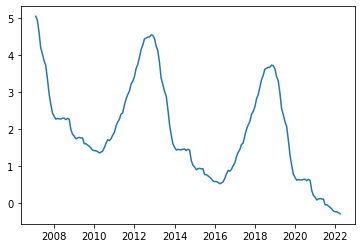

In [21]:
#Graphing the test predictions
y_hat_SARIMA_4 = results_4.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_SARIMA_4);

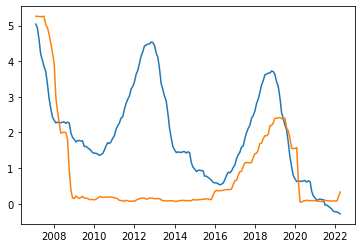

In [22]:
#Graphing test predictions vs test actual
fig, ax = plt.subplots()
ax.plot(y_hat_SARIMA_4)
ax.plot(test);

In [24]:
results_4.aic

-17.26660242244153

In [20]:
#Trying to run the computationally expensive 36 month seasonal term with order terms up to 8.
p = q = range(0, 9)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 36) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 36)
SARIMAX: (0, 1, 0) x (0, 1, 1, 36)
SARIMAX: (0, 1, 0) x (0, 1, 2, 36)
SARIMAX: (0, 1, 0) x (0, 1, 3, 36)
SARIMAX: (0, 1, 0) x (0, 1, 4, 36)
SARIMAX: (0, 1, 0) x (0, 1, 5, 36)
SARIMAX: (0, 1, 0) x (0, 1, 6, 36)
SARIMAX: (0, 1, 0) x (0, 1, 7, 36)
SARIMAX: (0, 1, 0) x (0, 1, 8, 36)
SARIMAX: (0, 1, 0) x (1, 1, 0, 36)
SARIMAX: (0, 1, 0) x (1, 1, 1, 36)
SARIMAX: (0, 1, 0) x (1, 1, 2, 36)
SARIMAX: (0, 1, 0) x (1, 1, 3, 36)
SARIMAX: (0, 1, 0) x (1, 1, 4, 36)
SARIMAX: (0, 1, 0) x (1, 1, 5, 36)
SARIMAX: (0, 1, 0) x (1, 1, 6, 36)
SARIMAX: (0, 1, 0) x (1, 1, 7, 36)
SARIMAX: (0, 1, 0) x (1, 1, 8, 36)
SARIMAX: (0, 1, 0) x (2, 1, 0, 36)
SARIMAX: (0, 1, 0) x (2, 1, 1, 36)
SARIMAX: (0, 1, 0) x (2, 1, 2, 36)
SARIMAX: (0, 1, 0) x (2, 1, 3, 36)
SARIMAX: (0, 1, 0) x (2, 1, 4, 36)
SARIMAX: (0, 1, 0) x (2, 1, 5, 36)
SARIMAX: (0, 1, 0) x (2, 1, 6, 36)
SARIMAX: (0, 1, 0) x (2, 1, 7, 36)
SARIMAX: (0, 1, 0) x (2, 1, 8, 36)
SARIMAX: (0, 1, 0) 

SARIMAX: (4, 1, 3) x (8, 1, 1, 36)
SARIMAX: (4, 1, 3) x (8, 1, 2, 36)
SARIMAX: (4, 1, 3) x (8, 1, 3, 36)
SARIMAX: (4, 1, 3) x (8, 1, 4, 36)
SARIMAX: (4, 1, 3) x (8, 1, 5, 36)
SARIMAX: (4, 1, 3) x (8, 1, 6, 36)
SARIMAX: (4, 1, 3) x (8, 1, 7, 36)
SARIMAX: (4, 1, 3) x (8, 1, 8, 36)
SARIMAX: (4, 1, 4) x (0, 1, 0, 36)
SARIMAX: (4, 1, 4) x (0, 1, 1, 36)
SARIMAX: (4, 1, 4) x (0, 1, 2, 36)
SARIMAX: (4, 1, 4) x (0, 1, 3, 36)
SARIMAX: (4, 1, 4) x (0, 1, 4, 36)
SARIMAX: (4, 1, 4) x (0, 1, 5, 36)
SARIMAX: (4, 1, 4) x (0, 1, 6, 36)
SARIMAX: (4, 1, 4) x (0, 1, 7, 36)
SARIMAX: (4, 1, 4) x (0, 1, 8, 36)
SARIMAX: (4, 1, 4) x (1, 1, 0, 36)
SARIMAX: (4, 1, 4) x (1, 1, 1, 36)
SARIMAX: (4, 1, 4) x (1, 1, 2, 36)
SARIMAX: (4, 1, 4) x (1, 1, 3, 36)
SARIMAX: (4, 1, 4) x (1, 1, 4, 36)
SARIMAX: (4, 1, 4) x (1, 1, 5, 36)
SARIMAX: (4, 1, 4) x (1, 1, 6, 36)
SARIMAX: (4, 1, 4) x (1, 1, 7, 36)
SARIMAX: (4, 1, 4) x (1, 1, 8, 36)
SARIMAX: (4, 1, 4) x (2, 1, 0, 36)
SARIMAX: (4, 1, 4) x (2, 1, 1, 36)
SARIMAX: (4, 1, 4) x

SARIMAX: (7, 1, 8) x (1, 1, 1, 36)
SARIMAX: (7, 1, 8) x (1, 1, 2, 36)
SARIMAX: (7, 1, 8) x (1, 1, 3, 36)
SARIMAX: (7, 1, 8) x (1, 1, 4, 36)
SARIMAX: (7, 1, 8) x (1, 1, 5, 36)
SARIMAX: (7, 1, 8) x (1, 1, 6, 36)
SARIMAX: (7, 1, 8) x (1, 1, 7, 36)
SARIMAX: (7, 1, 8) x (1, 1, 8, 36)
SARIMAX: (7, 1, 8) x (2, 1, 0, 36)
SARIMAX: (7, 1, 8) x (2, 1, 1, 36)
SARIMAX: (7, 1, 8) x (2, 1, 2, 36)
SARIMAX: (7, 1, 8) x (2, 1, 3, 36)
SARIMAX: (7, 1, 8) x (2, 1, 4, 36)
SARIMAX: (7, 1, 8) x (2, 1, 5, 36)
SARIMAX: (7, 1, 8) x (2, 1, 6, 36)
SARIMAX: (7, 1, 8) x (2, 1, 7, 36)
SARIMAX: (7, 1, 8) x (2, 1, 8, 36)
SARIMAX: (7, 1, 8) x (3, 1, 0, 36)
SARIMAX: (7, 1, 8) x (3, 1, 1, 36)
SARIMAX: (7, 1, 8) x (3, 1, 2, 36)
SARIMAX: (7, 1, 8) x (3, 1, 3, 36)
SARIMAX: (7, 1, 8) x (3, 1, 4, 36)
SARIMAX: (7, 1, 8) x (3, 1, 5, 36)
SARIMAX: (7, 1, 8) x (3, 1, 6, 36)
SARIMAX: (7, 1, 8) x (3, 1, 7, 36)
SARIMAX: (7, 1, 8) x (3, 1, 8, 36)
SARIMAX: (7, 1, 8) x (4, 1, 0, 36)
SARIMAX: (7, 1, 8) x (4, 1, 1, 36)
SARIMAX: (7, 1, 8) x

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
            #results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 0, 36) - AIC:1049.033879910419


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 1, 36) - AIC:768.1091050219326


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 2, 36) - AIC:602.7462577144815


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 1, 3, 36) - AIC:12262.615147340604


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 1, 4, 36) - AIC:141.69695113244097


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 5, 36) - AIC:-6.8888247385489905


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 6, 36) - AIC:-30.882177978881877


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 7, 36) - AIC:-46.912283094280696


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(0, 1, 8, 36) - AIC:-13.2243671470159


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 0, 36) - AIC:876.0151211827905


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 1, 36) - AIC:772.5991983902655


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 2, 36) - AIC:540.0557189793092


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 1, 3, 36) - AIC:5738.188312492944


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 4, 36) - AIC:138.3353920569691


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 5, 36) - AIC:-9.396358335055282


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 6, 36) - AIC:-33.23115691719619


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 7, 36) - AIC:-45.414529307872755


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(1, 1, 8, 36) - AIC:-16.573839751757205


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 0, 36) - AIC:639.0302085046445


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 1, 36) - AIC:631.0761532418358


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 2, 36) - AIC:615.1388259202229


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(2, 1, 3, 36) - AIC:5278.955425603842


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 4, 36) - AIC:108.35815223378087


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 5, 36) - AIC:-7.646276024403761


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(2, 1, 6, 36) - AIC:-35.09172098500129


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 7, 36) - AIC:-45.44814411134779


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(2, 1, 8, 36) - AIC:-14.619547016081704


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(3, 1, 0, 36) - AIC:286.480308158028


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(3, 1, 1, 36) - AIC:272.09588684419066


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(3, 1, 2, 36) - AIC:240.28229299004374


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(3, 1, 3, 36) - AIC:11126.701662144587


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(3, 1, 4, 36) - AIC:97.58044629399609


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(3, 1, 5, 36) - AIC:-6.750833710924233


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(3, 1, 6, 36) - AIC:-33.0941887340691


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(3, 1, 7, 36) - AIC:-43.4538355054746


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(3, 1, 8, 36) - AIC:-12.825231858085772


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(4, 1, 0, 36) - AIC:109.00662156358727


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(4, 1, 1, 36) - AIC:77.58776769693172


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(4, 1, 2, 36) - AIC:69.39726157698374


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(4, 1, 3, 36) - AIC:9547.081631542089


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(4, 1, 4, 36) - AIC:69.06887152845354


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(4, 1, 5, 36) - AIC:-7.880786154780495


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(4, 1, 6, 36) - AIC:-31.370800030782362


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(4, 1, 7, 36) - AIC:-44.64627098984171


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(4, 1, 8, 36) - AIC:-10.943514688306863


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(5, 1, 0, 36) - AIC:1.414012894197512


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(5, 1, 1, 36) - AIC:-10.00564980833208


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(5, 1, 2, 36) - AIC:4.350242775415271


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(5, 1, 3, 36) - AIC:1934.4475828267914


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(5, 1, 4, 36) - AIC:-8.82760717011913


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(5, 1, 5, 36) - AIC:-6.071769260864457


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(5, 1, 6, 36) - AIC:-29.683329390272092


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(5, 1, 7, 36) - AIC:-42.853959201795476


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(5, 1, 8, 36) - AIC:-9.40780755578242


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(6, 1, 0, 36) - AIC:-35.79056405810964


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(6, 1, 1, 36) - AIC:-34.32537142261387


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(6, 1, 2, 36) - AIC:-33.937318850340404


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(6, 1, 3, 36) - AIC:4428.567661703264


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(6, 1, 4, 36) - AIC:-31.08451064325716


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(6, 1, 5, 36) - AIC:-29.08465104523463


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(6, 1, 6, 36) - AIC:-27.711498585639994


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(6, 1, 7, 36) - AIC:-46.147158960493186


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(6, 1, 8, 36) - AIC:-11.386158705744492


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(7, 1, 0, 36) - AIC:-41.761027678415836


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(7, 1, 1, 36) - AIC:-50.24659335454942


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(7, 1, 2, 36) - AIC:-49.62166056288763


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(7, 1, 3, 36) - AIC:-47.88794919685567


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(7, 1, 4, 36) - AIC:-45.89226777761917


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(7, 1, 5, 36) - AIC:-43.89244472121146


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(7, 1, 6, 36) - AIC:-41.892434228519164


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(7, 1, 7, 36) - AIC:-38.56170518539051


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(7, 1, 8, 36) - AIC:-8.808033008359857


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(8, 1, 0, 36) - AIC:-27.49948598932223


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 0)x(8, 1, 1, 36) - AIC:-29.160666051163055


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(8, 1, 2, 36) - AIC:-27.83660880680234


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(8, 1, 3, 36) - AIC:-26.0676674945192


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(8, 1, 4, 36) - AIC:-24.316791653875264


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(8, 1, 5, 36) - AIC:-22.33570320781918


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(8, 1, 6, 36) - AIC:-20.335484527554485


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(8, 1, 7, 36) - AIC:-18.336441977317058


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(8, 1, 8, 36) - AIC:-15.397441998678566


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 0, 36) - AIC:980.3326523240537


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 1, 36) - AIC:697.4703740046613


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 2, 36) - AIC:515.1022676298779


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 1, 3, 36) - AIC:12784.100934177568


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 4, 36) - AIC:82.30404921754294


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 5, 36) - AIC:-49.000494940499465


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 6, 36) - AIC:-53.87658457064907


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 7, 36) - AIC:-72.77684872850841


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(0, 1, 8, 36) - AIC:-32.10620525408678


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 0, 36) - AIC:808.0162393051514


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 1, 36) - AIC:697.1888837959848


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 2, 36) - AIC:439.4721478269279


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 1, 3, 36) - AIC:12518.070061294296


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 4, 36) - AIC:79.47041963639869


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 5, 36) - AIC:-48.80610451659449


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 6, 36) - AIC:-56.037670942595156


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 7, 36) - AIC:-70.95233859444768


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(1, 1, 8, 36) - AIC:-36.185501925184234


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 0, 36) - AIC:543.2009875611166


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 1, 36) - AIC:538.3662640088163


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 2, 36) - AIC:520.459600405657


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(2, 1, 3, 36) - AIC:12206.30877622347


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 4, 36) - AIC:63.19069824393152


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 5, 36) - AIC:-47.382808354038715


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 6, 36) - AIC:-56.8203871733256


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 7, 36) - AIC:-70.60304902024289


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 8, 36) - AIC:-40.15590762113767


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(3, 1, 0, 36) - AIC:233.8815152264784


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(3, 1, 1, 36) - AIC:217.8637320063189


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(3, 1, 2, 36) - AIC:195.18672189618584


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(3, 1, 3, 36) - AIC:12165.986434210372


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(3, 1, 4, 36) - AIC:53.376382513127865


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(3, 1, 5, 36) - AIC:-47.78224462824879


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(3, 1, 6, 36) - AIC:-54.82044637115496


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(3, 1, 7, 36) - AIC:-69.00224655909292


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(3, 1, 8, 36) - AIC:-37.928462747975395


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(4, 1, 0, 36) - AIC:57.39543882552427


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(4, 1, 1, 36) - AIC:36.98699474147024


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(4, 1, 2, 36) - AIC:35.88343135436022


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(4, 1, 3, 36) - AIC:5244.985969101044


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(4, 1, 4, 36) - AIC:37.2072805266334


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(4, 1, 5, 36) - AIC:-50.571766471158014


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(4, 1, 6, 36) - AIC:-53.86006029102536


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(4, 1, 7, 36) - AIC:-70.79582252598505


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(4, 1, 8, 36) - AIC:-36.978385401588895


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(5, 1, 0, 36) - AIC:-40.41256651576858


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(5, 1, 1, 36) - AIC:-44.21638851425181


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(5, 1, 2, 36) - AIC:-48.677142577683014


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(5, 1, 3, 36) - AIC:9374.249284686297


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(5, 1, 4, 36) - AIC:-44.61980902692058


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(5, 1, 5, 36) - AIC:-42.94509547304726


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(5, 1, 6, 36) - AIC:-52.095586820293164


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(5, 1, 7, 36) - AIC:-68.86311197238109


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(5, 1, 8, 36) - AIC:-34.978606360523585


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(6, 1, 0, 36) - AIC:-64.53494221300906


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(6, 1, 1, 36) - AIC:-66.8115728767452


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(6, 1, 2, 36) - AIC:-64.87285079584595


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(6, 1, 3, 36) - AIC:1768.3270253506666


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(6, 1, 4, 36) - AIC:-61.841975881035154


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(6, 1, 5, 36) - AIC:-59.84425164413621


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(6, 1, 6, 36) - AIC:-57.364488369884455


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(6, 1, 7, 36) - AIC:-71.96285925233178


C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


As we can see above, the iteration was not fully above to run. A computer with more computational ability is needed to run these iterations. Still, we see a set of parameters that produced an AIC of -72.77. This is the best AIC score to date so lets model those parameters and do time based cross validation.

In [ ]:
ARIMA(0, 1, 1)x(0, 1, 7, 36) - AIC:-72.77684872850841

In [22]:
#Using parameters with lowest AIC to create a model 
mod_5=SARIMAX(train,
                         order=(0,1,1),
                         seasonal_order=(0,1,7,36),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
results_5 = mod_5.fit()

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [23]:
#Train RMSE
results_5_preds = results_5.predict(start=train.index[0],end=train.index[-1], typ='levels')
np.sqrt(mean_squared_error(train, results_5_preds))

0.9404365420856902

In [24]:
#Validation Set RMSE
preds = results_5.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
true = train_with_ind.iloc[val_ind, -1]
print(np.sqrt(mean_squared_error(true, preds)))

0.18070712911085704


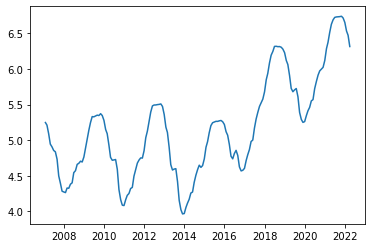

In [26]:
#Graphing test predictions
y_hat_SARIMA_5 = results_5.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_SARIMA_5);

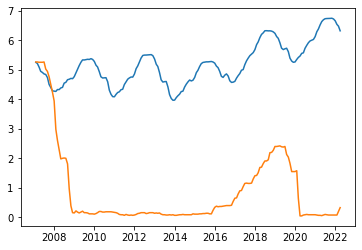

In [27]:
#Graphing test predictions vs test actual 
fig, ax = plt.subplots()
ax.plot(y_hat_SARIMA_5)
ax.plot(test);

In [28]:
results_5.aic

-72.77684872850841

In [ ]:
#FINAL TRY USING OPTIMAL ORDER TERMS AND SEASONAL TERMS
mod_6=SARIMAX(train,
                         order=(15,1,12),
                         seasonal_order=(0,1,4,72),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
results_6 = mod_6.fit()

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [30]:
##Train RMSE
results_6_preds = results_6.predict(start=train.index[0],end=train.index[-1], typ='levels')
np.sqrt(mean_squared_error(train, results_6_preds))

1.4841141236992341

In [31]:
#Validation Set RMSE
preds = results_6.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
true = train_with_ind.iloc[val_ind, -1]
print(np.sqrt(mean_squared_error(true, preds)))

0.17278051781661552


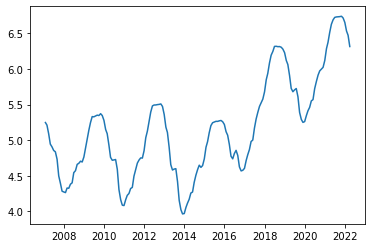

In [33]:
#Graphing Test Predictions
y_hat_SARIMA_6 = results_5.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_SARIMA_6);

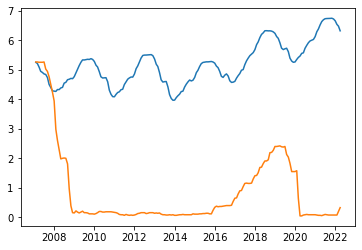

In [34]:
#Graphing test predictions vs test actual
fig, ax = plt.subplots()
ax.plot(y_hat_SARIMA_5)
ax.plot(test);

## Graphing Validation Scores for Each Type of Model

In [ ]:
3.6025620974745207 AR
3.567909740087694 MA
3.659361991910347 ARIMA
1.47438 SARIMA

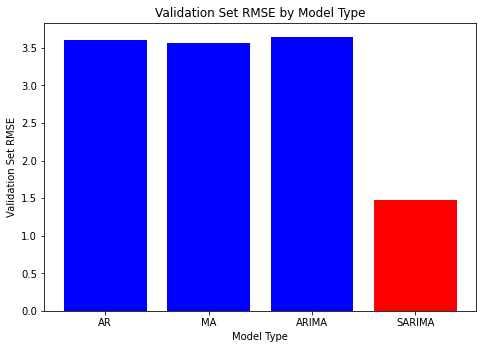

<Figure size 432x288 with 0 Axes>

In [59]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Model = ['AR', 'MA', 'ARIMA', 'SARIMA']
Score = [3.6,3.56,3.65,1.47]
plt.bar(Model,Score)

c = ['blue', 'blue', 'blue', 'red']
plt.bar(Model, height = Score, color = c)

ax.set_ylabel('Validation Set RMSE')
ax.set_xlabel('Model Type')
ax.set_title('Validation Set RMSE by Model Type')
plt.show()
#plt.savefig('1validation_RMSE_bymodel.png');

Here we can see each models performance against the validation set. Oddly, the ARIMA model that combines the AR & MA model performed the worst against the validation set. More research will need to be completed to figure out why. The red bar shows our best model, the SARIMA, which was off by 1.47 percentage points versus the validation set. 

## Final Evaluation of Models

When looking at the time based cross validation of the models, you can clearly see the SARIMA Models outperform with score as low as .17 versus higher than 3 for all other simpler models(RW, AR, MA, ARIMA). The SARIMA models also have a lower AIC score, while oddly largely having a higher RMSE on the training data. With that said, the SARIMA model is our best type of model. Now when selecting the best SARIMA we will look at the scores listed above as well as its graphed predictions on the test data. When looking at the full picture, it appears that the SARIMA model results_2 is the best model with an AR order term of 1 and a MA order term of zero with one level of differencing. The results_2 model also has a 72 month seasonal adjustment and a low AIC score of 38.8 and train RMSE score of .87 which was lower than a majority of the SARIMA models. As we can also see in the graph test predictions how far model 5 and 6 are from test actual despite the lower validation set RMSE. The results_2 SARIMA model is our best and well rounded model.

In [ ]:
##Test RMSE
results_2_preds_test = results_2.predict(start=test.index[0], end=test.index[-1], typ='levels')
np.sqrt(mean_squared_error(test, results_2_preds_test))

## Graphing Baseline Random Walk Model 

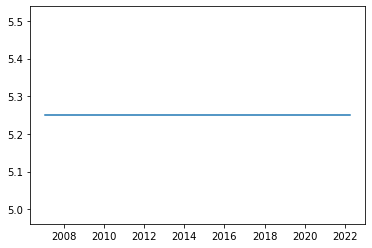

In [32]:
#Graphing RW_Model test predictions
y_hat_baseline = RW_model.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(y_hat_baseline);

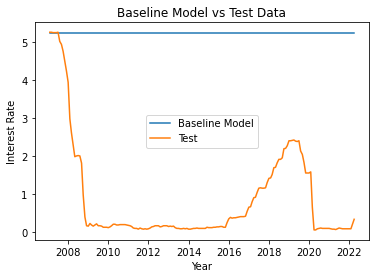

In [48]:
#Graphing RW model test predictions vs test actual
fig, ax = plt.subplots()
ax.plot(y_hat_baseline, label='Baseline Model')
ax.set_ylabel('Interest Rate')
ax.set_xlabel('Year')
ax.set_title('Baseline Model vs Test Data')
ax.plot(test, label='Test')
plt.legend();

Here we can see our final models performance (results_2 model above) against the baseline random walk model for the test data set. Our model was off by 1.92 percentage points against the test set, which is much improved from the 3.49 percentage points see above for the baseline model on the validation set. Our visuals here confirms our calculations.

In [39]:
RW_model.aic

822.762260190724

## Using our Best Model to Graph Forecast

In [81]:
##Retraining our best model on the entire data set
mod_2=SARIMAX(df_FF,
                         order=(1,1,0),
                         seasonal_order=(2,1,1,72),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
results_2 = mod_2.fit()

C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\mycha\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [82]:
#Best Model 5 year prediction values
forecast = results_2.forecast(steps=60)
forecast

2022-05-01    0.378152
2022-06-01    0.412468
2022-07-01    0.414342
2022-08-01    0.439330
2022-09-01    0.451658
2022-10-01    0.427928
2022-11-01    0.453830
2022-12-01    0.566208
2023-01-01    0.604782
2023-02-01    0.629488
2023-03-01    0.702725
2023-04-01    0.765447
2023-05-01    0.836422
2023-06-01    0.896400
2023-07-01    0.990661
2023-08-01    1.050546
2023-09-01    1.098388
2023-10-01    1.114575
2023-11-01    1.145901
2023-12-01    1.211376
2024-01-01    1.305074
2024-02-01    1.380482
2024-03-01    1.457235
2024-04-01    1.610586
2024-05-01    1.707506
2024-06-01    1.824715
2024-07-01    1.910221
2024-08-01    1.919282
2024-09-01    1.965271
2024-10-01    2.069525
2024-11-01    2.108114
2024-12-01    2.152019
2025-01-01    2.180825
2025-02-01    2.171729
2025-03-01    2.183826
2025-04-01    2.141764
2025-05-01    2.059294
2025-06-01    2.015780
2025-07-01    1.987270
2025-08-01    1.817073
2025-09-01    1.714073
2025-10-01    1.539015
2025-11-01    1.329620
2025-12-01 

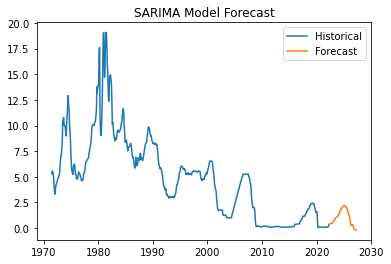

In [85]:
##Graphing Best Model 5 Year Forecast
fig, ax = plt.subplots()
ax.plot(df_FF, label='Historical')
ax.plot(forecast, label='Forecast')
ax.set_title('SARIMA Model Forecast')
plt.legend()
plt.savefig('SARIMA_forecast.png');

The five year forecast for our best SARIMA model has interest rates peaking in 2025 and actually going negative in 2026. This is quite the prediction, as the United States has never had negative interest rates, unlike their European and Japanese counterparts. 

## Conclusion

The Federal Funds Rate is the shortest term loan interest rate and is the foundation of credit markets. Our best model can be used to help predict and forecast the Federal Funds Rate, which in turn will guide financial institutions and emerging Fintech companies to avoid both credit and interest rate risk. We strive to utilize our model to limit credit/debt losses during periods of high stress and/or inflation. Our model was off by 1.92 percentage points versus the unseen test data which compares to 3.49 percentage points on the baseline Random Walk Model. Our best models AIC score also compares favorably, with an AIC score of 38.8 versus 822 for the baseline model. Lastly, our model forecasts interest rates increasing until 2025 until moving into negative rate territory in 2026, following Europe and Japan previously. With this forward-looking insight, lenders can limit credit losses by reducing exposure to credit on their balance sheet and slowing lending rates until the Federal Funds Rate peaks around 2025.